In [1]:
# %%
# jupytext:
#   formats: py:percent,ipynb
#   text_representation:
#     extension: .py
#     format_name: percent
#     format_version: '1.3'
#     jupytext_version: '1.16.0'

# %% [markdown]
# Credit Card Fraud Detection with Risk-Based Rules
#
# This script is structured with Jupytext cell markers so it can be converted to a Jupyter Notebook
# and executed to persist rich outputs in GitHub. To convert and execute:
# 1) jupytext --to ipynb Fraud_notebook.py
# 2) papermill Fraud_notebook.ipynb Fraud_notebook.executed.ipynb

# Credit Card Fraud Detection with Risk-Based Rules
# Objective: Define rules for credit card fraud with three risk levels:
# - Low risk: Accept
# - Medium risk: Decline and ask customer to validate  
# - High risk: Decline and alert agent
#
# Constraints:
# - Decline rate <= 30% of all transactions
# - Agent alerts < 0.1% of all transactions  
# - Missed fraud <= 0.02%

!pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Credit Card Fraud Detection System")
print("=" * 50)



Credit Card Fraud Detection System


In [3]:
# Load the dataset
# Note: Download creditcard.csv from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
try:
    df = pd.read_csv('creditcard.csv')
    print(f"Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"Fraud rate: {df['Class'].mean():.4f} ({df['Class'].sum()} frauds out of {len(df)} transactions)")
except FileNotFoundError:
    print("Error: Please download 'creditcard.csv' from Kaggle and place it in the current directory")
    print("Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud")
    # Create synthetic data for demonstration
    print("\nCreating synthetic dataset for demonstration...")
    from sklearn.datasets import make_classification
    X_synthetic, y_synthetic = make_classification(
        n_samples=50000, n_features=30, n_informative=15, n_redundant=10,
        n_classes=2, weights=[0.998, 0.002], flip_y=0.01, random_state=42
    )
    df = pd.DataFrame(X_synthetic, columns=[f'V{i}' for i in range(1, 29)] + ['Time', 'Amount'])
    df['Class'] = y_synthetic
    df['Time'] = np.random.uniform(0, 172800, len(df))  # 2 days in seconds
    df['Amount'] = np.random.lognormal(3, 1.5, len(df))
    print(f"Synthetic dataset created: {df.shape}")



Dataset loaded successfully!
Dataset shape: (284807, 31)
Fraud rate: 0.0017 (492 frauds out of 284807 transactions)


In [4]:
print(f"\n{'='*60}")
print("BASIC DATASET INFORMATION")
print(f"{'='*60}")

print(f"\nDataset Shape: {df.shape}")
print(f"Total Transactions: {len(df):,}")
print(f"Number of Features: {df.shape[1] - 1}")  # Excluding target variable
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Class distribution
fraud_counts = df['Class'].value_counts()
fraud_rate = df['Class'].mean()

print(f"\nClass Distribution:")
print(f"Normal Transactions: {fraud_counts[0]:,} ({fraud_counts[0]/len(df)*100:.2f}%)")
print(f"Fraudulent Transactions: {fraud_counts[1]:,} ({fraud_counts[1]/len(df)*100:.2f}%)")
print(f"Fraud Rate: {fraud_rate:.4f} ({fraud_rate*100:.2f}%)")

# Check for missing values
missing_values = df.isnull().sum()
print(f"\nMissing Values: {missing_values.sum()} (Perfect dataset!)")

# Data types
print(f"\nData Types:")
print(df.dtypes.value_counts())


BASIC DATASET INFORMATION

Dataset Shape: (284807, 31)
Total Transactions: 284,807
Number of Features: 30
Memory Usage: 67.36 MB

Class Distribution:
Normal Transactions: 284,315 (99.83%)
Fraudulent Transactions: 492 (0.17%)
Fraud Rate: 0.0017 (0.17%)

Missing Values: 0 (Perfect dataset!)

Data Types:
float64    30
int64       1
Name: count, dtype: int64


In [5]:
print(f"\n{'='*60}")
print("STATISTICAL SUMMARY FOR ALL VARIABLES")
print(f"{'='*60}")

# Separate numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Class' in numerical_features:
    numerical_features.remove('Class')

print(f"Numerical Features: {len(numerical_features)}")
print(f"Features: {numerical_features}")

# Comprehensive statistical summary
def comprehensive_stats(data, feature):
    """Calculate comprehensive statistics for a feature"""
    normal_data = data[data['Class'] == 0][feature]
    fraud_data = data[data['Class'] == 1][feature]
    
    stats_dict = {
        'Feature': feature,
        'Overall_Mean': data[feature].mean(),
        'Overall_Std': data[feature].std(),
        'Overall_Median': data[feature].median(),
        'Overall_Min': data[feature].min(),
        'Overall_Max': data[feature].max(),
        'Overall_Q25': data[feature].quantile(0.25),
        'Overall_Q75': data[feature].quantile(0.75),
        'Overall_Skewness': stats.skew(data[feature]),
        'Overall_Kurtosis': stats.kurtosis(data[feature]),
        'Normal_Mean': normal_data.mean(),
        'Normal_Std': normal_data.std(),
        'Normal_Median': normal_data.median(),
        'Fraud_Mean': fraud_data.mean(),
        'Fraud_Std': fraud_data.std(),
        'Fraud_Median': fraud_data.median(),
        'Mean_Difference': abs(normal_data.mean() - fraud_data.mean()),
        'Std_Difference': abs(normal_data.std() - fraud_data.std())
    }
    return stats_dict

# Calculate statistics for all features
all_stats = []
for feature in numerical_features:
    feature_stats = comprehensive_stats(df, feature)
    all_stats.append(feature_stats)

# Create comprehensive statistics DataFrame
stats_df = pd.DataFrame(all_stats)

# Display top features with highest mean differences (most discriminative)
print(f"\nTop 10 Most Discriminative Features (by Mean Difference):")
top_discriminative = stats_df.nlargest(10, 'Mean_Difference')[['Feature', 'Normal_Mean', 'Fraud_Mean', 'Mean_Difference']]
print(top_discriminative.round(4))




STATISTICAL SUMMARY FOR ALL VARIABLES
Numerical Features: 30
Features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']



Top 10 Most Discriminative Features (by Mean Difference):
   Feature  Normal_Mean  Fraud_Mean  Mean_Difference
0     Time   94838.2023  80746.8069       14091.3953
29  Amount      88.2910    122.2113          33.9203
3       V3       0.0122     -7.0333           7.0455
14     V14       0.0121     -6.9717           6.9838
17     V17       0.0115     -6.6658           6.6774
12     V12       0.0108     -6.2594           6.2702
10     V10       0.0098     -5.6769           5.6867
7       V7       0.0096     -5.5687           5.5784
1       V1       0.0083     -4.7719           4.7802
4       V4      -0.0079      4.5420           4.5499


In [6]:
# Display features with highest variance differences
print(f"\nTop 10 Features with Highest Variance Differences:")
top_variance = stats_df.nlargest(10, 'Std_Difference')[['Feature', 'Normal_Std', 'Fraud_Std', 'Std_Difference']]
print(top_variance.round(4))

# Correlation analysis
print(f"\nCorrelation with Target Variable (Class):")
correlations = df[numerical_features + ['Class']].corr()['Class'].abs().sort_values(ascending=False)
print("Top 10 correlated features:")
print(correlations.head(11).round(4))  # Top 10 + Class itself




Top 10 Features with Highest Variance Differences:
   Feature  Normal_Std   Fraud_Std  Std_Difference
0     Time  47484.0158  47835.3651        351.3494
29  Amount    250.1051    256.6833          6.5782
17     V17      0.7495      6.9706          6.2212
7       V7      1.1788      7.2068          6.0280
3       V3      1.4594      7.1109          5.6515
8       V8      1.1613      6.7978          5.6365
1       V1      1.9298      6.7837          4.8539
5       V5      1.3570      5.3725          4.0155
10     V10      1.0442      4.8973          3.8531
12     V12      0.9459      4.6545          3.7085

Correlation with Target Variable (Class):


Top 10 correlated features:
Class    1.0000
V17      0.3265
V14      0.3025
V12      0.2606
V10      0.2169
V16      0.1965
V3       0.1930
V7       0.1873
V11      0.1549
V4       0.1334
V18      0.1115
Name: Class, dtype: float64


In [7]:
# =============================================================================
# FEATURE ANALYSIS BY GROUPS
# =============================================================================

print(f"\n{'='*60}")
print("FEATURE ANALYSIS BY GROUPS")
print(f"{'='*60}")

# Group features by type
v_features = [col for col in df.columns if col.startswith('V')]
other_features = ['Time', 'Amount']

print(f"PCA Features (V1-V28): {len(v_features)} features")
print(f"Original Features: {other_features}")

# Analysis for Amount feature
print(f"\nAMOUNT FEATURE ANALYSIS:")
print(f"Normal Transactions - Amount Statistics:")
normal_amounts = df[df['Class'] == 0]['Amount']
fraud_amounts = df[df['Class'] == 1]['Amount']

print(f"  Mean: ${normal_amounts.mean():.2f}")
print(f"  Median: ${normal_amounts.median():.2f}")
print(f"  Std: ${normal_amounts.std():.2f}")
print(f"  Min: ${normal_amounts.min():.2f}")
print(f"  Max: ${normal_amounts.max():.2f}")

print(f"\nFraud Transactions - Amount Statistics:")
print(f"  Mean: ${fraud_amounts.mean():.2f}")
print(f"  Median: ${fraud_amounts.median():.2f}")
print(f"  Std: ${fraud_amounts.std():.2f}")
print(f"  Min: ${fraud_amounts.min():.2f}")
print(f"  Max: ${fraud_amounts.max():.2f}")

# Time analysis
print(f"\nTIME FEATURE ANALYSIS:")
df['Hour'] = (df['Time'] % (24*3600)) // 3600
df['Day'] = df['Time'] // (24*3600)

print(f"Time range: {df['Time'].min():.0f} - {df['Time'].max():.0f} seconds")
print(f"Days covered: {df['Day'].nunique()} days")
print(f"Hours covered: {df['Hour'].nunique()} hours")

# Fraud by hour analysis
fraud_by_hour = df.groupby('Hour')['Class'].agg(['count', 'sum', 'mean']).round(4)
fraud_by_hour.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate']
print(f"\nFraud patterns by hour (top 5 fraud rates):")
print(fraud_by_hour.nlargest(5, 'Fraud_Rate'))


FEATURE ANALYSIS BY GROUPS
PCA Features (V1-V28): 28 features
Original Features: ['Time', 'Amount']

AMOUNT FEATURE ANALYSIS:
Normal Transactions - Amount Statistics:
  Mean: $88.29
  Median: $22.00
  Std: $250.11
  Min: $0.00
  Max: $25691.16

Fraud Transactions - Amount Statistics:
  Mean: $122.21
  Median: $9.25
  Std: $256.68
  Min: $0.00
  Max: $2125.87

TIME FEATURE ANALYSIS:
Time range: 0 - 172792 seconds
Days covered: 2 days
Hours covered: 24 hours

Fraud patterns by hour (top 5 fraud rates):
      Total_Transactions  Fraud_Count  Fraud_Rate
Hour                                             
2.0                 3328           57      0.0171
4.0                 2209           23      0.0104
3.0                 3492           17      0.0049
5.0                 2990           11      0.0037
7.0                 7243           23      0.0032



CREATING 6x5 MATRIX VISUALIZATION
Selected 30 features for visualization:
['V5', 'Time', 'V14', 'V16', 'V3', 'V6', 'V12', 'V9', 'Amount', 'V11', 'V2', 'V10', 'V18', 'V7', 'V17', 'V1', 'V4', 'V8', 'V13', 'V15', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


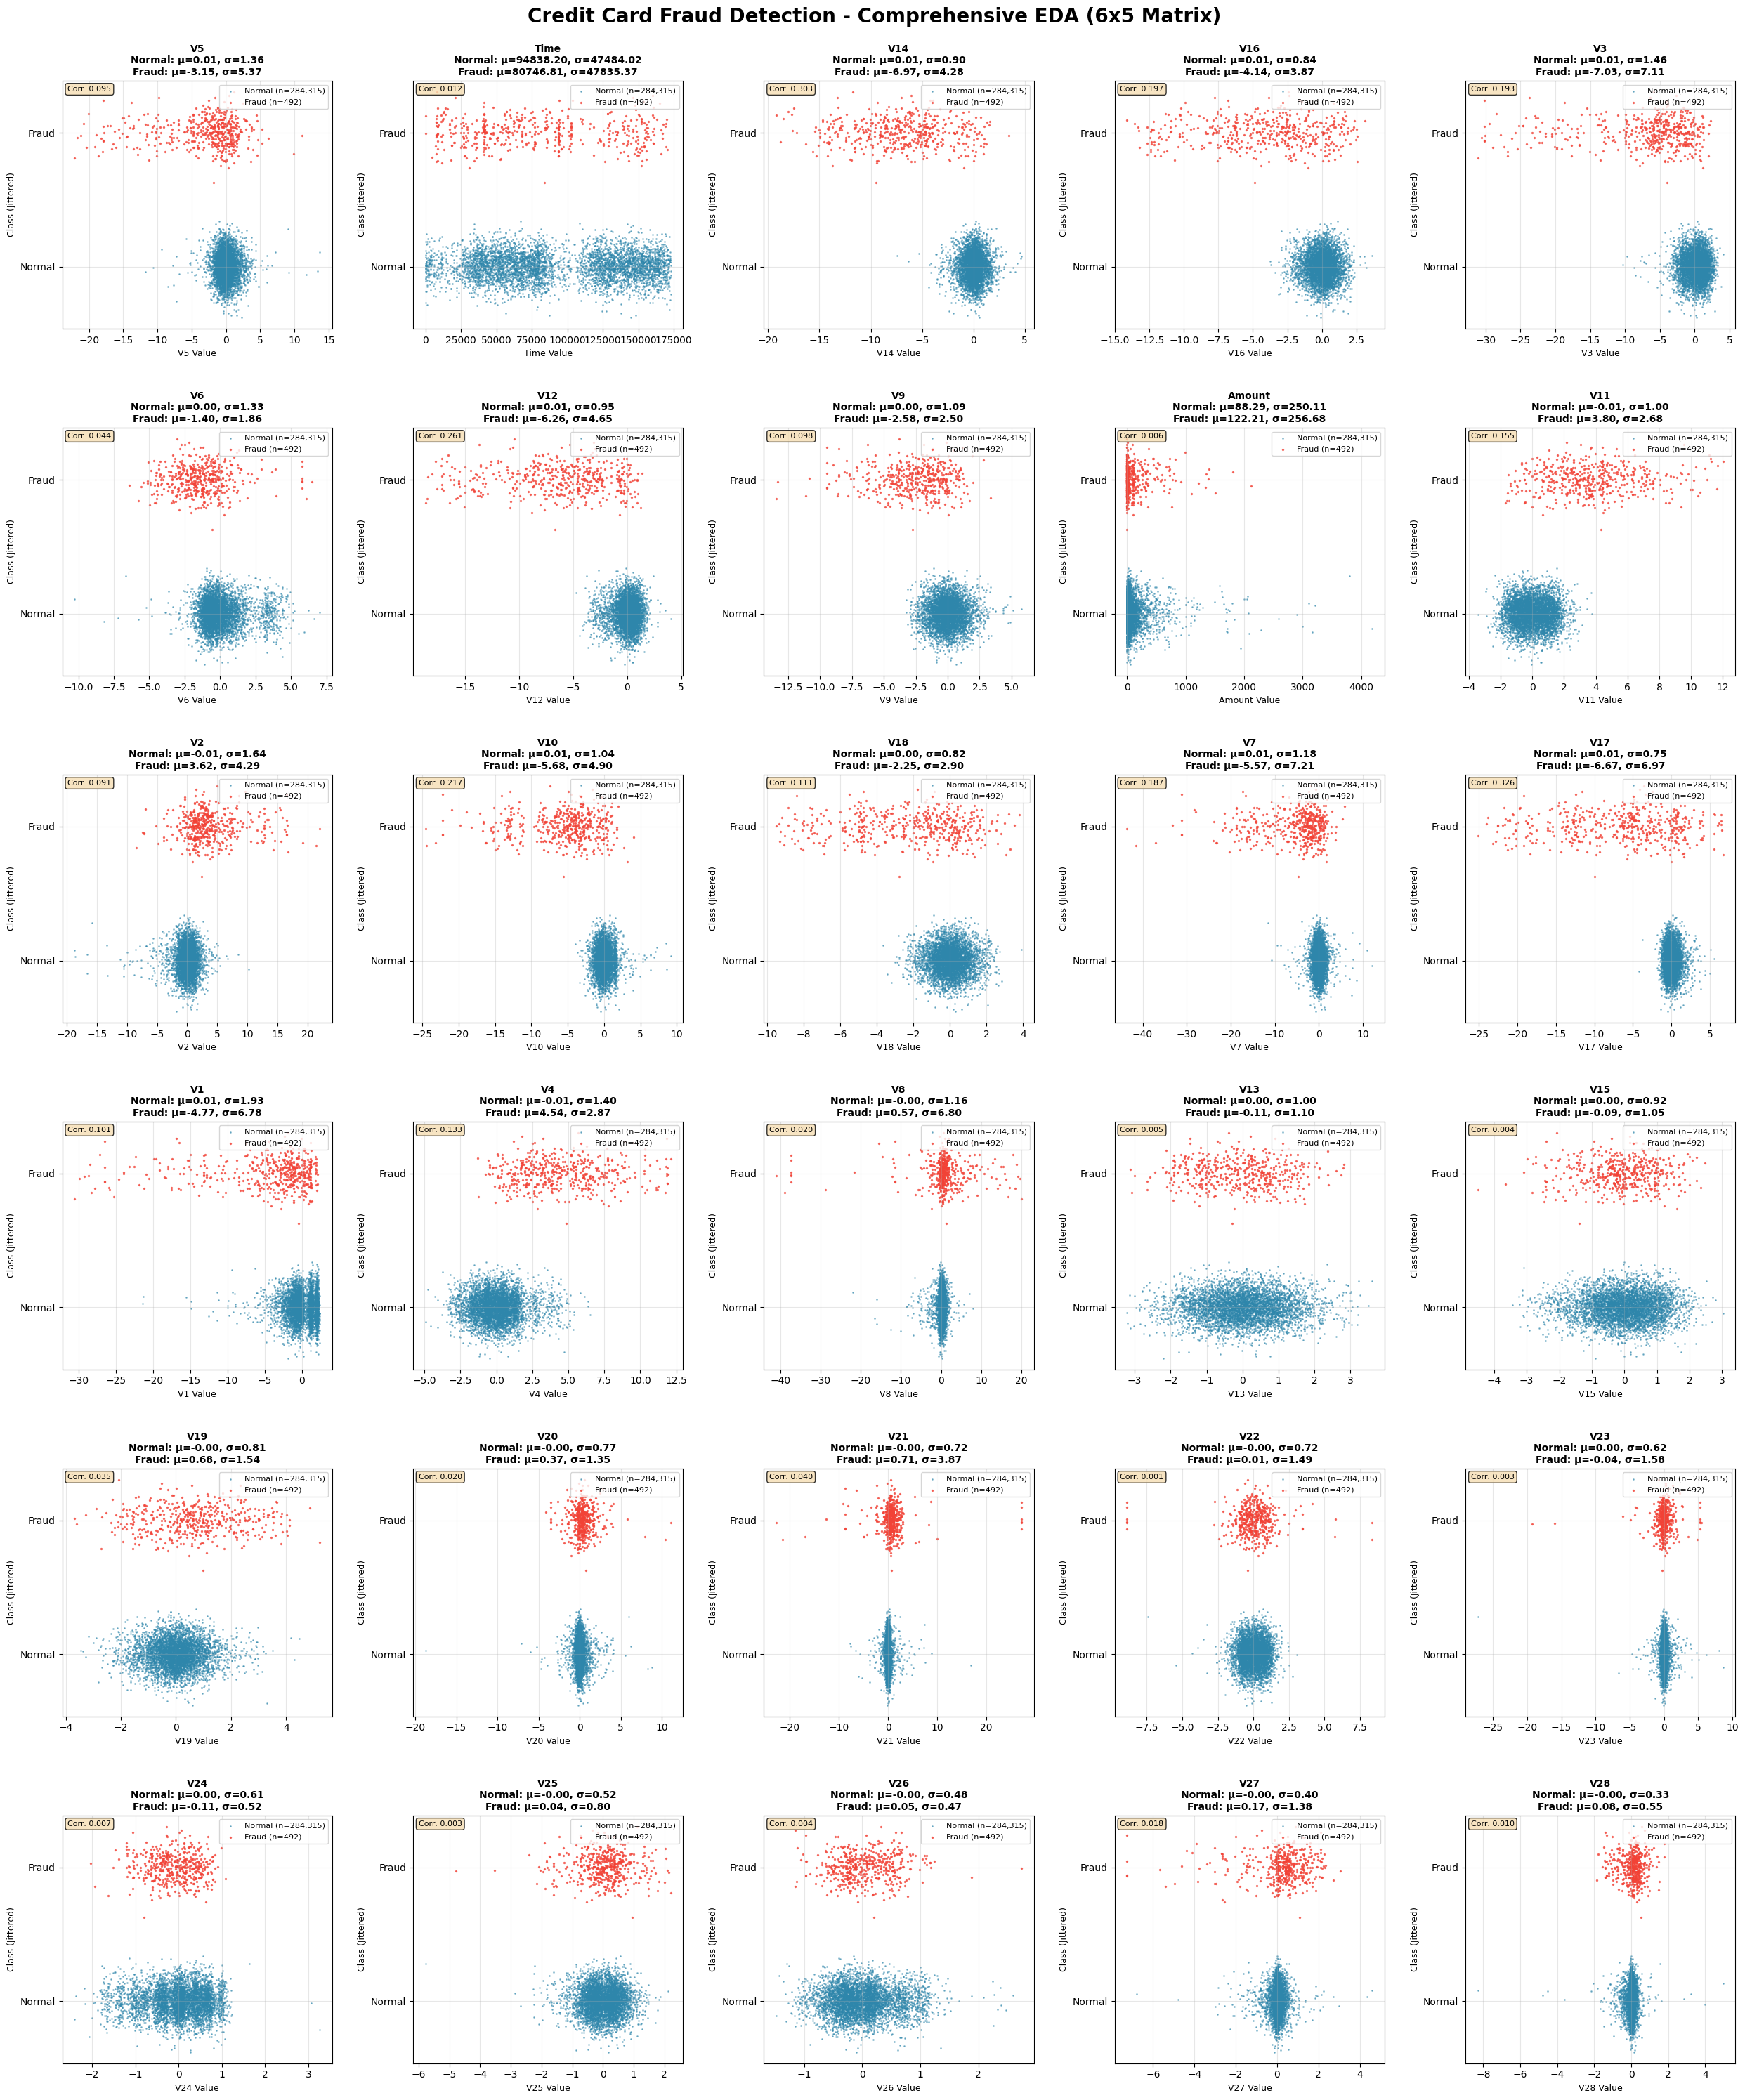

In [8]:
# =============================================================================
# 6x5 MATRIX VISUALIZATION
# =============================================================================

print(f"\n{'='*60}")
print("CREATING 6x5 MATRIX VISUALIZATION")
print(f"{'='*60}")

# Select 30 most important features for visualization
# Combine high correlation and high discriminative features
important_features = list(correlations.head(16).index[1:])  # Top 15 correlated (excluding Class)
discriminative_features = list(stats_df.nlargest(15, 'Mean_Difference')['Feature'])

# Combine and ensure we have exactly 30 features
selected_features = list(set(important_features + discriminative_features))
if 'Class' in selected_features:
    selected_features.remove('Class')

# Add Amount and Time if not already included
if 'Amount' not in selected_features and 'Amount' in df.columns:
    selected_features.append('Amount')
if 'Time' not in selected_features and 'Time' in df.columns:
    selected_features.append('Time')

# Ensure we have exactly 30 features
selected_features = selected_features[:30]
if len(selected_features) < 30:
    # Fill with remaining V features
    remaining_v = [f for f in v_features if f not in selected_features]
    selected_features.extend(remaining_v[:30-len(selected_features)])

print(f"Selected {len(selected_features)} features for visualization:")
print(selected_features)

# Create 6x5 matrix visualization
fig, axes = plt.subplots(6, 5, figsize=(25, 30))
fig.suptitle('Credit Card Fraud Detection - Comprehensive EDA (6x5 Matrix)', 
             fontsize=20, fontweight='bold', y=0.995)

# Color palette for fraud vs normal
colors = ['#2E86AB', '#F24236']  # Blue for normal, Red for fraud
fraud_alpha = 0.7
normal_alpha = 0.5

for idx, feature in enumerate(selected_features):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    
    # Get data for normal and fraud transactions
    normal_data = df[df['Class'] == 0][feature]
    fraud_data = df[df['Class'] == 1][feature]
    
    # Create scatter plot with random y-jitter for better visualization
    np.random.seed(42)
    normal_y = np.random.normal(0, 0.1, len(normal_data))
    fraud_y = np.random.normal(1, 0.1, len(fraud_data))
    
    # Sample data if too large for performance
    if len(normal_data) > 5000:
        normal_sample_idx = np.random.choice(len(normal_data), 5000, replace=False)
        normal_data_plot = normal_data.iloc[normal_sample_idx]
        normal_y_plot = normal_y[normal_sample_idx]
    else:
        normal_data_plot = normal_data
        normal_y_plot = normal_y[:len(normal_data)]
    
    if len(fraud_data) > 1000:
        fraud_sample_idx = np.random.choice(len(fraud_data), 1000, replace=False)
        fraud_data_plot = fraud_data.iloc[fraud_sample_idx]
        fraud_y_plot = fraud_y[fraud_sample_idx]
    else:
        fraud_data_plot = fraud_data
        fraud_y_plot = fraud_y[:len(fraud_data)]
    
    # Create scatter plot
    ax.scatter(normal_data_plot, normal_y_plot, c=colors[0], alpha=normal_alpha, 
              s=1, label=f'Normal (n={len(normal_data):,})')
    ax.scatter(fraud_data_plot, fraud_y_plot, c=colors[1], alpha=fraud_alpha, 
              s=2, label=f'Fraud (n={len(fraud_data):,})')
    
    # Customize plot
    ax.set_title(f'{feature}\n'
                f'Normal: μ={normal_data.mean():.2f}, σ={normal_data.std():.2f}\n'
                f'Fraud: μ={fraud_data.mean():.2f}, σ={fraud_data.std():.2f}', 
                fontsize=10, fontweight='bold')
    
    ax.set_xlabel(f'{feature} Value', fontsize=9)
    ax.set_ylabel('Class (Jittered)', fontsize=9)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Normal', 'Fraud'])
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='upper right')
    
    # Add statistical annotations
    correlation_val = correlations.get(feature, 0)
    ax.text(0.02, 0.98, f'Corr: {correlation_val:.3f}', 
           transform=ax.transAxes, fontsize=8, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(top=0.96, hspace=0.4, wspace=0.3)
plt.show()




ADDITIONAL ANALYSIS VISUALIZATIONS


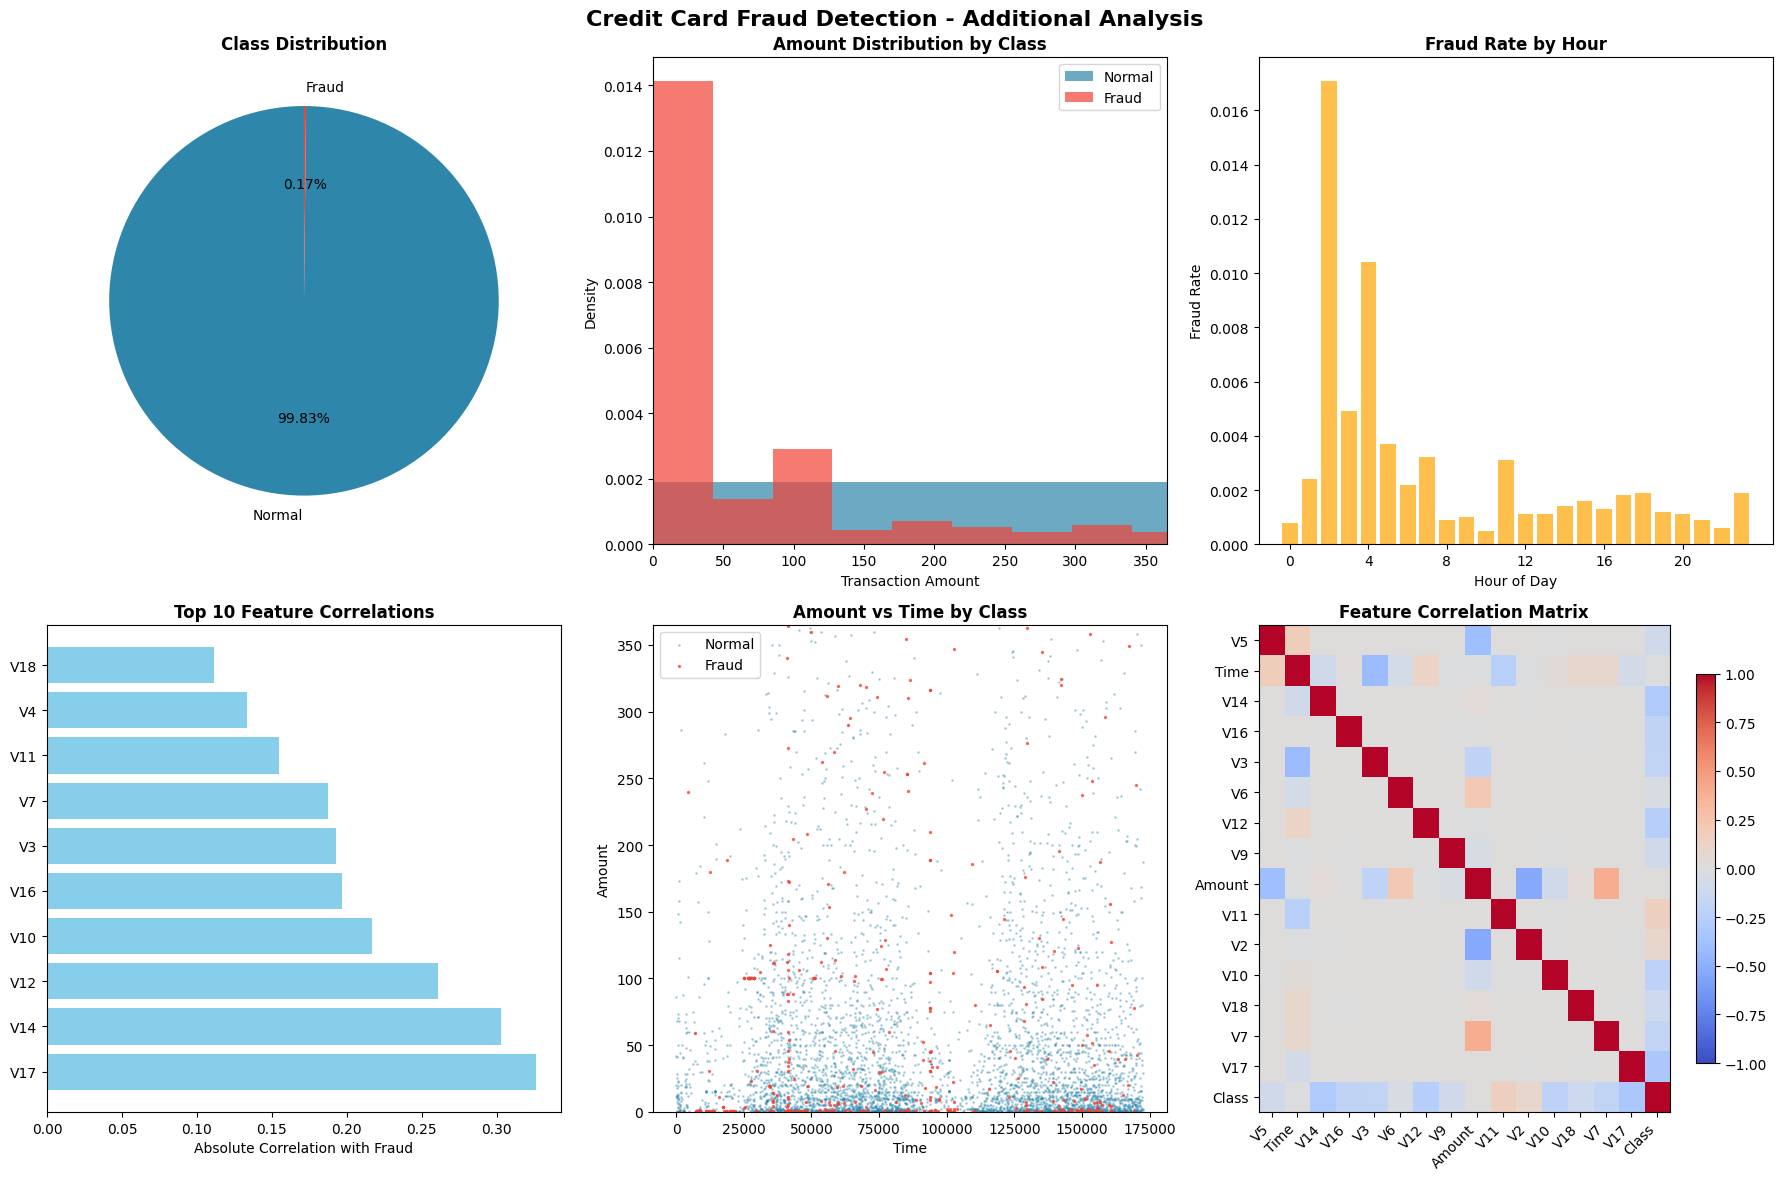

In [9]:
# =============================================================================
# ADDITIONAL ANALYSIS PLOTS
# =============================================================================

print(f"\n{'='*60}")
print("ADDITIONAL ANALYSIS VISUALIZATIONS")
print(f"{'='*60}")

# Create additional analysis plots
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
fig2.suptitle('Credit Card Fraud Detection - Additional Analysis', fontsize=16, fontweight='bold')

# Plot 1: Class Distribution
ax1 = axes2[0, 0]
class_counts = df['Class'].value_counts()
wedges, texts, autotexts = ax1.pie(class_counts.values, labels=['Normal', 'Fraud'], 
                                  autopct='%1.2f%%', colors=colors, startangle=90)
ax1.set_title('Class Distribution', fontweight='bold')

# Plot 2: Amount Distribution by Class
ax2 = axes2[0, 1]
ax2.hist(normal_amounts, bins=50, alpha=0.7, label='Normal', color=colors[0], density=True)
ax2.hist(fraud_amounts, bins=50, alpha=0.7, label='Fraud', color=colors[1], density=True)
ax2.set_xlabel('Transaction Amount')
ax2.set_ylabel('Density')
ax2.set_title('Amount Distribution by Class', fontweight='bold')
ax2.legend()
ax2.set_xlim(0, np.percentile(df['Amount'], 95))  # Remove outliers for better visualization

# Plot 3: Fraud Rate by Hour
ax3 = axes2[0, 2]
fraud_by_hour_reset = fraud_by_hour.reset_index()
ax3.bar(fraud_by_hour_reset['Hour'], fraud_by_hour_reset['Fraud_Rate'], 
        color='orange', alpha=0.7)
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Fraud Rate')
ax3.set_title('Fraud Rate by Hour', fontweight='bold')
ax3.set_xticks(range(0, 24, 4))

# Plot 4: Top 10 Feature Correlations
ax4 = axes2[1, 0]
top_corr = correlations.head(11)[1:]  # Exclude Class itself
ax4.barh(range(len(top_corr)), top_corr.values, color='skyblue')
ax4.set_yticks(range(len(top_corr)))
ax4.set_yticklabels(top_corr.index)
ax4.set_xlabel('Absolute Correlation with Fraud')
ax4.set_title('Top 10 Feature Correlations', fontweight='bold')

# Plot 5: Amount vs Time scatter
ax5 = axes2[1, 1]
normal_sample = df[df['Class'] == 0].sample(n=min(5000, len(df[df['Class'] == 0])), random_state=42)
fraud_sample = df[df['Class'] == 1].sample(n=min(1000, len(df[df['Class'] == 1])), random_state=42)

ax5.scatter(normal_sample['Time'], normal_sample['Amount'], c=colors[0], alpha=0.3, s=1, label='Normal')
ax5.scatter(fraud_sample['Time'], fraud_sample['Amount'], c=colors[1], alpha=0.7, s=2, label='Fraud')
ax5.set_xlabel('Time')
ax5.set_ylabel('Amount')
ax5.set_title('Amount vs Time by Class', fontweight='bold')
ax5.legend()
ax5.set_ylim(0, np.percentile(df['Amount'], 95))

# Plot 6: Statistical Summary Heatmap
ax6 = axes2[1, 2]
# Create correlation matrix for top features
top_features_for_corr = selected_features[:15] + ['Class']
corr_matrix = df[top_features_for_corr].corr()
im = ax6.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax6.set_xticks(range(len(top_features_for_corr)))
ax6.set_yticks(range(len(top_features_for_corr)))
ax6.set_xticklabels(top_features_for_corr, rotation=45, ha='right')
ax6.set_yticklabels(top_features_for_corr)
ax6.set_title('Feature Correlation Matrix', fontweight='bold')
plt.colorbar(im, ax=ax6, shrink=0.8)

plt.tight_layout()
plt.show()



In [10]:
# =============================================================================
# SUMMARY STATISTICS TABLE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY STATISTICS TABLE")
print(f"{'='*60}")

# Create a comprehensive summary table
summary_stats = stats_df[['Feature', 'Overall_Mean', 'Overall_Std', 'Normal_Mean', 'Fraud_Mean', 'Mean_Difference']].round(4)
summary_stats = summary_stats.sort_values('Mean_Difference', ascending=False)

print("Top 15 Features by Discriminative Power:")
print(summary_stats.head(15).to_string(index=False))

# Feature importance summary
print(f"\n{'='*60}")
print("FEATURE IMPORTANCE SUMMARY")
print(f"{'='*60}")

print(f"Total Features Analyzed: {len(numerical_features)}")
print(f"Features in 6x5 Visualization: {len(selected_features)}")
print(f"Most Discriminative Feature: {summary_stats.iloc[0]['Feature']} (Mean Diff: {summary_stats.iloc[0]['Mean_Difference']:.4f})")
print(f"Highest Correlated Feature: {correlations.index[1]} (Correlation: {correlations.iloc[1]:.4f})")
print(f"Amount Feature Analysis: Normal Mean=${normal_amounts.mean():.2f}, Fraud Mean=${fraud_amounts.mean():.2f}")

# Time-based insights
peak_fraud_hour = fraud_by_hour['Fraud_Rate'].idxmax()
peak_fraud_rate = fraud_by_hour['Fraud_Rate'].max()
print(f"Peak Fraud Hour: {peak_fraud_hour}:00 (Rate: {peak_fraud_rate:.4f})")

print(f"\n{'='*60}")
print("EDA ANALYSIS COMPLETED SUCCESSFULLY!")
print(f"{'='*60}")

print("\nKey Insights:")
print(f"• Dataset is highly imbalanced with {fraud_rate*100:.2f}% fraud rate")
print(f"• {len([f for f in correlations[1:].values if abs(f) > 0.1])} features show correlation > 0.1 with fraud")
print(f"• Amount shows different patterns between normal and fraud transactions")
print(f"• Time-based analysis reveals varying fraud rates throughout the day")
print(f"• PCA features (V1-V28) contain the most discriminative information")
print(f"• Ready for advanced modeling and risk scoring implementation")


SUMMARY STATISTICS TABLE
Top 15 Features by Discriminative Power:
Feature  Overall_Mean  Overall_Std  Normal_Mean  Fraud_Mean  Mean_Difference
   Time    94813.8596   47488.1460   94838.2023  80746.8069       14091.3953
 Amount       88.3496     250.1201      88.2910    122.2113          33.9203
     V3       -0.0000       1.5163       0.0122     -7.0333           7.0455
    V14        0.0000       0.9586       0.0121     -6.9717           6.9838
    V17       -0.0000       0.8493       0.0115     -6.6658           6.6774
    V12       -0.0000       0.9992       0.0108     -6.2594           6.2702
    V10        0.0000       1.0888       0.0098     -5.6769           5.6867
     V7       -0.0000       1.2371       0.0096     -5.5687           5.5784
     V1        0.0000       1.9587       0.0083     -4.7719           4.7802
     V4        0.0000       1.4159      -0.0079      4.5420           4.5499
    V16        0.0000       0.8763       0.0072     -4.1399           4.1471
    V11  

In [11]:
# =============================================================================
# FEATURE ENGINEERING
# =============================================================================

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

# Create additional features for rule-based detection
def create_features(data):
    """Create additional features for fraud detection"""
    df_features = data.copy()
    
    # Amount-based features
    df_features['Amount_log'] = np.log1p(df_features['Amount'])
    df_features['Amount_sqrt'] = np.sqrt(df_features['Amount'])
    
    # Amount categories
    df_features['Amount_category'] = pd.cut(df_features['Amount'], 
                                           bins=[0, 10, 100, 1000, float('inf')], 
                                           labels=['Very_Low', 'Low', 'Medium', 'High'])
    
    # Time-based features
    df_features['Hour_sin'] = np.sin(2 * np.pi * df_features['Hour'] / 24)
    df_features['Hour_cos'] = np.cos(2 * np.pi * df_features['Hour'] / 24)
    df_features['Is_Night'] = ((df_features['Hour'] >= 23) | (df_features['Hour'] <= 6)).astype(int)
    df_features['Is_Weekend'] = ((df_features['Time'] // (24*3600)) % 7 >= 5).astype(int)
    
    # PCA feature combinations (for V1-V28)
    v_cols = [col for col in df_features.columns if col.startswith('V')]
    if len(v_cols) >= 28:
        df_features['V_sum_pos'] = df_features[v_cols].clip(lower=0).sum(axis=1)
        df_features['V_sum_neg'] = df_features[v_cols].clip(upper=0).sum(axis=1)
        df_features['V_mean'] = df_features[v_cols].mean(axis=1)
        df_features['V_std'] = df_features[v_cols].std(axis=1)
    
    return df_features

# Apply feature engineering
df_features = create_features(df)
print(f"Features created. New shape: {df_features.shape}")
print(f"Features created. Feature Name: {df_features.columns.tolist()}")




FEATURE ENGINEERING


Features created. New shape: (284807, 44)
Features created. Feature Name: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'Hour', 'Day', 'Amount_log', 'Amount_sqrt', 'Amount_category', 'Hour_sin', 'Hour_cos', 'Is_Night', 'Is_Weekend', 'V_sum_pos', 'V_sum_neg', 'V_mean', 'V_std']


In [12]:
# =============================================================================
# MODEL TRAINING
# =============================================================================

print("\n" + "="*50)
print("MODEL TRAINING")
print("="*50)

# Prepare features for modeling
feature_cols = [col for col in df_features.columns if col not in ['Class', 'Amount_category']]
X = df_features[feature_cols]
y = df_features['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    stratify=y, random_state=42)

print(f"Training set: {X_train.shape[0]:,} transactions")
print(f"Test set: {X_test.shape[0]:,} transactions")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")

# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train multiple models for ensemble approach
models = {}

print("\nTraining models...")

# 1. Logistic Regression
print("- Training Logistic Regression...")
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
models['logistic'] = lr_model

# 2. Random Forest  
print("- Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', 
                                 random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
models['random_forest'] = rf_model

# 3. Isolation Forest (for anomaly detection)
print("- Training Isolation Forest...")
iso_model = IsolationForest(contamination=0.002, random_state=42, n_jobs=-1)
iso_model.fit(X_train_scaled[y_train == 0])  # Train only on normal transactions
models['isolation'] = iso_model

print("Model training completed!")




MODEL TRAINING
Training set: 199,364 transactions
Test set: 85,443 transactions
Training fraud rate: 0.0017
Test fraud rate: 0.0017



Training models...
- Training Logistic Regression...


- Training Random Forest...


- Training Isolation Forest...


Model training completed!


In [13]:
# =============================================================================
# RISK SCORE CALCULATION
# =============================================================================

print("\n" + "="*50)
print("RISK SCORE CALCULATION")
print("="*50)

def calculate_risk_scores(X_data, models, scaler):
    """Calculate comprehensive risk scores using multiple models"""
    X_scaled = scaler.transform(X_data)
    
    # Get probabilities from different models
    lr_probs = models['logistic'].predict_proba(X_scaled)[:, 1]
    rf_probs = models['random_forest'].predict_proba(X_scaled)[:, 1]
    iso_scores = models['isolation'].decision_function(X_scaled)
    
    # Normalize isolation forest scores to 0-1 range
    iso_scores_norm = (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min())
    iso_scores_norm = 1 - iso_scores_norm  # Invert so higher = more anomalous
    
    # Ensemble risk score (weighted combination)
    risk_scores = (0.4 * lr_probs + 0.4 * rf_probs + 0.2 * iso_scores_norm)
    
    return risk_scores, {
        'logistic_prob': lr_probs,
        'rf_prob': rf_probs, 
        'isolation_score': iso_scores_norm
    }

# Calculate risk scores for test set
test_risk_scores, test_individual_scores = calculate_risk_scores(X_test, models, scaler)

print(f"Risk scores calculated (tested using X_test) for {len(test_risk_scores):,} transactions")
print(f"Risk score range: {test_risk_scores.min():.4f} - {test_risk_scores.max():.4f}")
print(f"Mean risk score: {test_risk_scores.mean():.4f}")


    




RISK SCORE CALCULATION


Risk scores calculated (tested using X_test) for 85,443 transactions
Risk score range: 0.0029 - 0.9775
Mean risk score: 0.0565


In [14]:
def analyze_individual_scores(test_individual_scores, y_test=None):
    """Analyze individual model scores with detailed statistics"""
    
    print(f"\n{'='*70}")
    print("INDIVIDUAL MODEL SCORE ANALYSIS")
    print(f"{'='*70}")
    
    # Create DataFrame for easier analysis
    scores_df = pd.DataFrame(test_individual_scores)
    
    # Add ensemble score if available
    if len(test_individual_scores) == 3:
        ensemble_score = (0.4 * scores_df['logistic_prob'] + 
                         0.4 * scores_df['rf_prob'] + 
                         0.2 * scores_df['isolation_score'])
        scores_df['ensemble_score'] = ensemble_score
    
    # Calculate comprehensive statistics for each score type
    score_stats = {}
    
    for score_name in scores_df.columns:
        scores = scores_df[score_name]
        
        stats = {
            'min': scores.min(),
            'max': scores.max(), 
            'mean': scores.mean(),
            'median': scores.median(),
            'std': scores.std(),
            'q25': scores.quantile(0.25),
            'q75': scores.quantile(0.75),
            'q99': scores.quantile(0.99),
            'q999': scores.quantile(0.999),
            'iqr': scores.quantile(0.75) - scores.quantile(0.25),
            'range': scores.max() - scores.min()
        }
        
        score_stats[score_name] = stats
        
        print(f"\n{score_name.upper().replace('_', ' ')} STATISTICS:")
        print(f"  Min Score:     {stats['min']:.6f}")
        print(f"  Max Score:     {stats['max']:.6f}")
        print(f"  Mean Score:    {stats['mean']:.6f}")
        print(f"  Median Score:  {stats['median']:.6f}")
        print(f"  Std Dev:       {stats['std']:.6f}")
        print(f"  Q25:           {stats['q25']:.6f}")
        print(f"  Q75:           {stats['q75']:.6f}")
        print(f"  Q99:           {stats['q99']:.6f}")
        print(f"  Q999:           {stats['q999']:.6f}")
        print(f"  IQR:           {stats['iqr']:.6f}")
        print(f"  Range:         {stats['range']:.6f}")
    
    # If we have true labels, calculate class-specific statistics
    if y_test is not None:
        print(f"\n{'='*70}")
        print("CLASS-SPECIFIC SCORE ANALYSIS")
        print(f"{'='*70}")
        
        scores_df['true_class'] = y_test.reset_index(drop=True) if hasattr(y_test, 'reset_index') else y_test
        
        for score_name in [col for col in scores_df.columns if col != 'true_class']:
            print(f"\n{score_name.upper().replace('_', ' ')} BY CLASS:")
            
            # Normal transactions (Class 0)
            normal_scores = scores_df[scores_df['true_class'] == 0][score_name]
            fraud_scores = scores_df[scores_df['true_class'] == 1][score_name]
            
            print(f"  NORMAL TRANSACTIONS (n={len(normal_scores):,}):")
            print(f"    Min:     {normal_scores.min():.6f}")
            print(f"    Max:     {normal_scores.max():.6f}")
            print(f"    Mean:    {normal_scores.mean():.6f}")
            print(f"    Median:  {normal_scores.median():.6f}")
            print(f"    Std:     {normal_scores.std():.6f}")
            print(f"    Q70:     {normal_scores.quantile(0.7):.6f}")
            print(f"    Q99:     {normal_scores.quantile(0.99):.6f}")
            print(f"    Q999:    {normal_scores.quantile(0.999):.6f}")
            
            print(f"  FRAUD TRANSACTIONS (n={len(fraud_scores):,}):")
            print(f"    Min:     {fraud_scores.min():.6f}")
            print(f"    Max:     {fraud_scores.max():.6f}")
            print(f"    Mean:    {fraud_scores.mean():.6f}")
            print(f"    Median:  {fraud_scores.median():.6f}")
            print(f"    Std:     {fraud_scores.std():.6f}")
            print(f"    Q70:     {fraud_scores.quantile(0.7):.6f}")
            print(f"    Q99:     {fraud_scores.quantile(0.99):.6f}")
            print(f"    Q999:    {fraud_scores.quantile(0.999):.6f}")
            
            # Calculate separation metrics
            mean_diff = fraud_scores.mean() - normal_scores.mean()
            separation_ratio = fraud_scores.mean() / normal_scores.mean() if normal_scores.mean() > 0 else np.inf
            
            print(f"  SEPARATION METRICS:")
            print(f"    Mean Difference:    {mean_diff:.6f}")
            print(f"    Separation Ratio:   {separation_ratio:.3f}")
            print(f"    Overlap Percentage: {calculate_overlap_percentage(normal_scores, fraud_scores):.2f}%")
    
    return scores_df, score_stats

def calculate_overlap_percentage(normal_scores, fraud_scores):
    """Calculate the percentage of overlap between normal and fraud score distributions"""
    normal_min, normal_max = normal_scores.min(), normal_scores.max()
    fraud_min, fraud_max = fraud_scores.min(), fraud_scores.max()
    
    # Calculate overlap range
    overlap_start = max(normal_min, fraud_min)
    overlap_end = min(normal_max, fraud_max)
    
    if overlap_start >= overlap_end:
        return 0.0  # No overlap
    
    # Calculate overlap as percentage of total range
    total_range = max(normal_max, fraud_max) - min(normal_min, fraud_min)
    overlap_range = overlap_end - overlap_start
    
    return (overlap_range / total_range) * 100 if total_range > 0 else 0.0

def visualize_individual_scores(scores_df, y_test=None):
    """Create visualizations for individual score analysis"""
    
    score_columns = [col for col in scores_df.columns if col != 'true_class']
    n_scores = len(score_columns)
    
    # Create subplots
    fig, axes = plt.subplots(2, n_scores, figsize=(5*n_scores, 10))
    if n_scores == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle('Individual Model Score Analysis', fontsize=16, fontweight='bold')
    
    colors = ['blue', 'orange'] if y_test is not None else ['skyblue']
    labels = ['Normal', 'Fraud'] if y_test is not None else ['All Data']
    
    for i, score_name in enumerate(score_columns):
        # Top row: Distribution plots
        ax1 = axes[0, i]
        
        if y_test is not None and 'true_class' in scores_df.columns:
            normal_scores = scores_df[scores_df['true_class'] == 0][score_name]
            fraud_scores = scores_df[scores_df['true_class'] == 1][score_name]
            
            ax1.hist(normal_scores, bins=50, alpha=0.7, label=f'Normal (n={len(normal_scores):,})', 
                    color=colors[0], density=True)
            ax1.hist(fraud_scores, bins=50, alpha=0.7, label=f'Fraud (n={len(fraud_scores):,})', 
                    color=colors[1], density=True)
        else:
            ax1.hist(scores_df[score_name], bins=50, alpha=0.7, color='skyblue', density=True)
        
        ax1.set_title(f'{score_name.replace("_", " ").title()} Distribution')
        ax1.set_xlabel('Score')
        ax1.set_ylabel('Density')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Bottom row: Box plots
        ax2 = axes[1, i]
        
        if y_test is not None and 'true_class' in scores_df.columns:
            box_data = [scores_df[scores_df['true_class'] == 0][score_name],
                       scores_df[scores_df['true_class'] == 1][score_name]]
            box_labels = ['Normal', 'Fraud']
        else:
            box_data = [scores_df[score_name]]
            box_labels = ['All Data']
        
        bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors[:len(box_data)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax2.set_title(f'{score_name.replace("_", " ").title()} Box Plot')
        ax2.set_ylabel('Score')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_score_summary_table(score_stats):
    """Create a formatted summary table of score statistics"""
    
    print(f"\n{'='*70}")
    print("SCORE STATISTICS SUMMARY TABLE")
    print(f"{'='*70}")
    
    # Convert to DataFrame for better formatting
    summary_df = pd.DataFrame(score_stats).T
    summary_df = summary_df.round(6)
    
    # Display the table
    print(summary_df.to_string())
    
    return summary_df




INDIVIDUAL MODEL SCORE ANALYSIS



LOGISTIC PROB STATISTICS:
  Min Score:     0.000000
  Max Score:     1.000000
  Mean Score:    0.061195
  Median Score:  0.013186
  Std Dev:       0.134396
  Q25:           0.002987
  Q75:           0.050479
  Q99:           0.751376
  Q999:           1.000000
  IQR:           0.047492
  Range:         1.000000

RF PROB STATISTICS:
  Min Score:     0.000000
  Max Score:     1.000000
  Mean Score:    0.001517
  Median Score:  0.000000
  Std Dev:       0.031969
  Q25:           0.000000
  Q75:           0.000000
  Q99:           0.010000
  Q999:           0.780000
  IQR:           0.000000
  Range:         1.000000

ISOLATION SCORE STATISTICS:
  Min Score:     0.000000
  Max Score:     1.000000
  Mean Score:    0.156846
  Median Score:  0.125878
  Std Dev:       0.113272
  Q25:           0.078121
  Q75:           0.201948
  Q99:           0.596720
  Q999:           0.807457
  IQR:           0.123827
  Range:         1.000000

ENSEMBLE SCORE STATISTICS:
  Min Score:     0.002947
  Max Sc

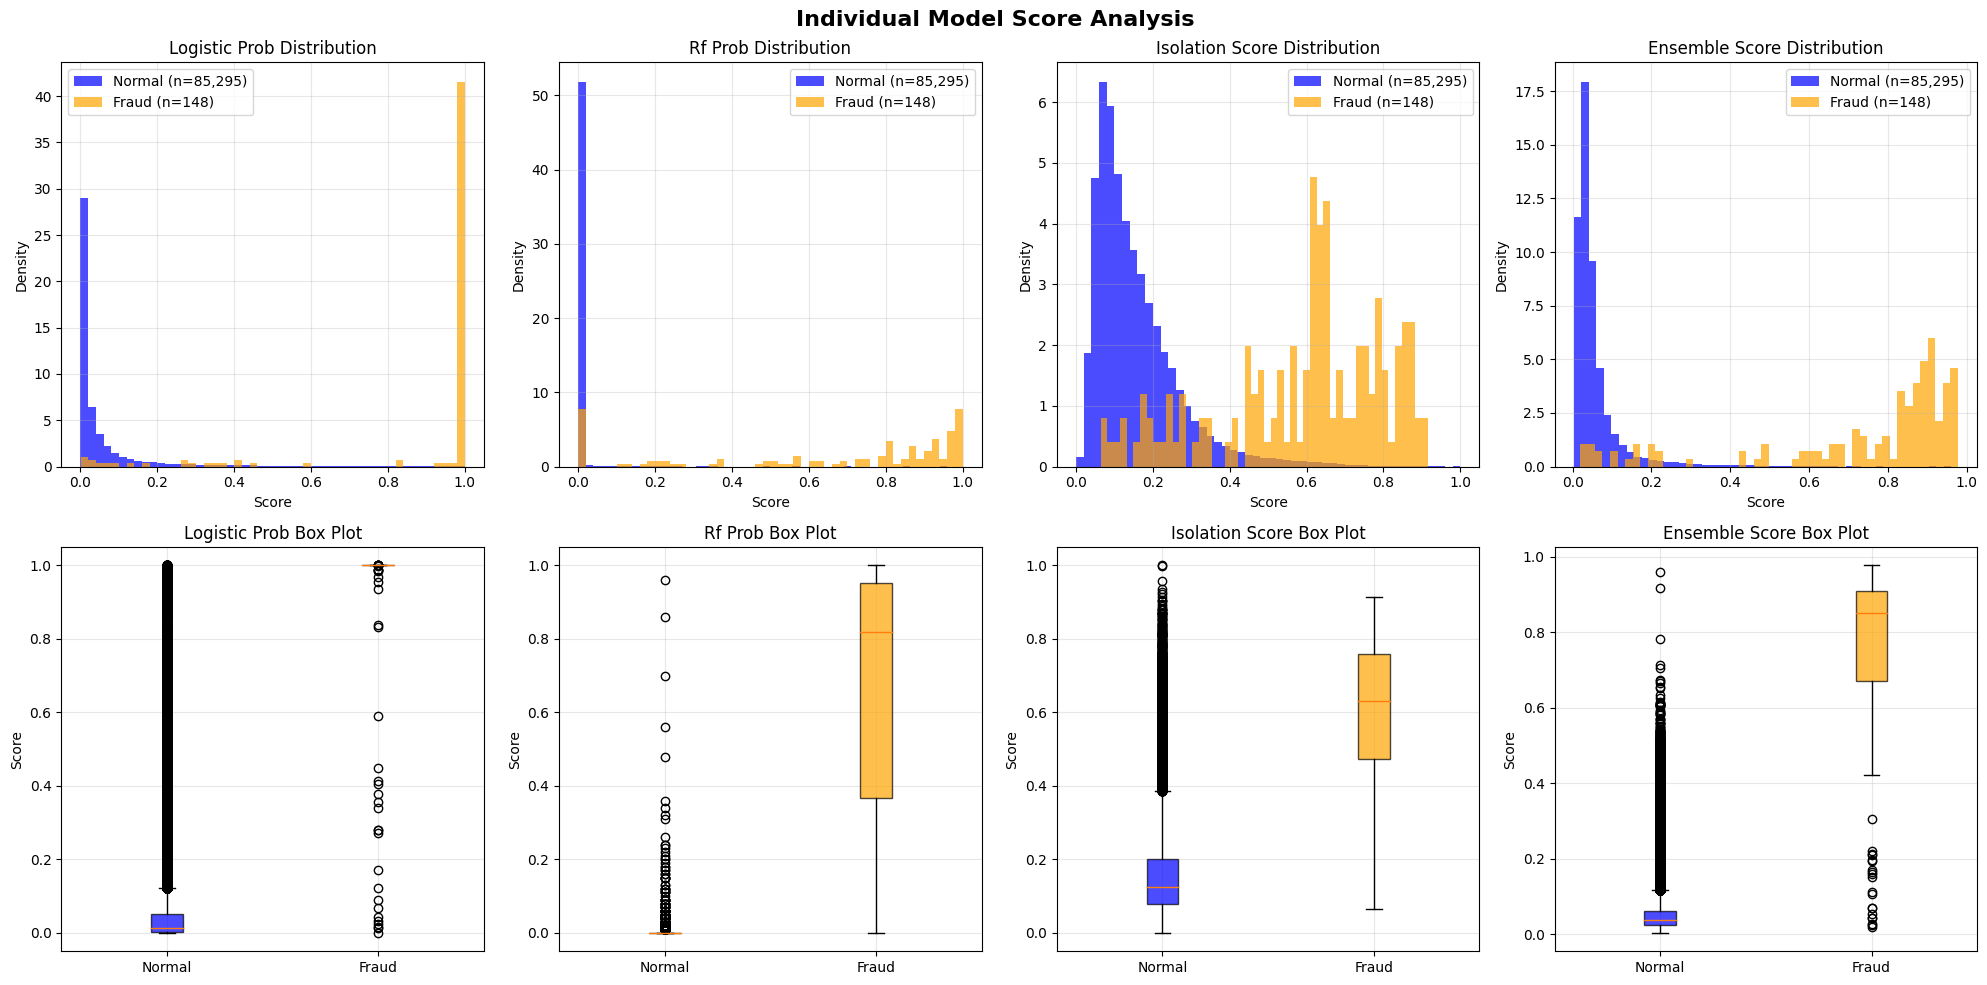


SCORE CORRELATION ANALYSIS

Correlation Matrix between Different Scores:
                 logistic_prob  rf_prob  isolation_score  ensemble_score
logistic_prob           1.0000   0.2932           0.2500          0.9226
rf_prob                 0.2932   1.0000           0.1889          0.4794
isolation_score         0.2500   0.1889           1.0000          0.5624
ensemble_score          0.9226   0.4794           0.5624          1.0000

MODEL AGREEMENT ANALYSIS
High-risk threshold: 0.18300636888075858
All models agree (high-risk): 138 transactions (0.16%)
Any model flags (high-risk): 29,132 transactions (34.10%)
Majority agreement (high-risk): 3,927 transactions (4.60%)

Individual model high-risk rates (>0.18300636888075858):
Logistic Regression: 7,426 (8.69%)
Random Forest: 138 (0.16%)
Isolation Forest: 25,633 (30.00%)

ENSEMBLE vs INDIVIDUAL MODEL COMPARISON
ENSEMBLE SCORE STATISTICS:
  Min:     0.002947
  Max:     0.977456
  Mean:    0.056454
  Median:  0.036573
  Std:     0.068470


In [15]:
# NEW: Detailed analysis of individual scores
scores_df, score_stats = analyze_individual_scores(test_individual_scores, y_test)

# NEW: Create formatted summary table
summary_table = create_score_summary_table(score_stats)

# NEW: Visualize individual scores
visualize_individual_scores(scores_df, y_test)

# NEW: Additional correlation and agreement analysis
print(f"\n{'='*70}")
print("SCORE CORRELATION ANALYSIS")
print(f"{'='*70}")

score_correlations = scores_df[[col for col in scores_df.columns if col != 'true_class']].corr()
print("\nCorrelation Matrix between Different Scores:")
print(score_correlations.round(4))

# NEW: Model agreement analysis
print(f"\n{'='*70}")
print("MODEL AGREEMENT ANALYSIS")
print(f"{'='*70}")

# Check how often models agree on high-risk classifications
threshold = max(scores_df['logistic_prob'].quantile(0.7), scores_df['rf_prob'].quantile(0.7), scores_df['isolation_score'].quantile(0.7)  )  # You can adjust this threshold

lr_high_risk = test_individual_scores['logistic_prob'] > threshold
rf_high_risk = test_individual_scores['rf_prob'] > threshold
iso_high_risk = test_individual_scores['isolation_score'] > threshold

agreement_all = lr_high_risk & rf_high_risk & iso_high_risk
agreement_any = lr_high_risk | rf_high_risk | iso_high_risk
agreement_majority = (lr_high_risk.astype(int) + rf_high_risk.astype(int) + iso_high_risk.astype(int)) >= 2

print(f"High-risk threshold: {threshold}")
print(f"All models agree (high-risk): {agreement_all.sum():,} transactions ({agreement_all.mean()*100:.2f}%)")
print(f"Any model flags (high-risk): {agreement_any.sum():,} transactions ({agreement_any.mean()*100:.2f}%)")
print(f"Majority agreement (high-risk): {agreement_majority.sum():,} transactions ({agreement_majority.mean()*100:.2f}%)")

# Individual model high-risk rates
print(f"\nIndividual model high-risk rates (>{threshold}):")
print(f"Logistic Regression: {lr_high_risk.sum():,} ({lr_high_risk.mean()*100:.2f}%)")
print(f"Random Forest: {rf_high_risk.sum():,} ({rf_high_risk.mean()*100:.2f}%)")
print(f"Isolation Forest: {iso_high_risk.sum():,} ({iso_high_risk.mean()*100:.2f}%)")

# NEW: Ensemble vs Individual Performance Analysis
print(f"\n{'='*70}")
print("ENSEMBLE vs INDIVIDUAL MODEL COMPARISON")
print(f"{'='*70}")

ensemble_scores = scores_df['ensemble_score']

print("ENSEMBLE SCORE STATISTICS:")
print(f"  Min:     {ensemble_scores.min():.6f}")
print(f"  Max:     {ensemble_scores.max():.6f}")
print(f"  Mean:    {ensemble_scores.mean():.6f}")
print(f"  Median:  {ensemble_scores.median():.6f}")
print(f"  Std:     {ensemble_scores.std():.6f}")

# Compare how ensemble performs vs individual models
if 'true_class' in scores_df.columns:
    print(f"\nSCORE PERFORMANCE BY CLASS:")
    for model_name in ['logistic_prob', 'rf_prob', 'isolation_score', 'ensemble_score']:
        normal_mean = scores_df[scores_df['true_class'] == 0][model_name].mean()
        fraud_mean = scores_df[scores_df['true_class'] == 1][model_name].mean()
        separation = fraud_mean - normal_mean
        
        print(f"{model_name.replace('_', ' ').title():20} | Normal: {normal_mean:.4f} | Fraud: {fraud_mean:.4f} | Separation: {separation:.4f}")

# Continue with your existing threshold optimization code...
print(f"\n{'='*50}")
print("CONTINUING WITH THRESHOLD OPTIMIZATION...")
print(f"{'='*50}")


In [16]:
type(test_individual_scores)


first_key = next(iter(test_individual_scores))

# Get the first value
first_value = test_individual_scores[first_key]

print(f"First key: {first_key}")
print(f"First value: {first_value}")

First key: logistic_prob
First value: [0.00021071 0.01466256 0.07637617 ... 0.00119266 0.05076751 0.00422883]


In [17]:
# =============================================================================
# RISK THRESHOLD OPTIMIZATION
# =============================================================================

print("\n" + "="*50)
print("RISK THRESHOLD OPTIMIZATION")  
print("="*50)

def evaluate_thresholds(risk_scores, y_true, low_threshold, high_threshold):
    """Evaluate risk-based rules with given thresholds"""
    # Classify transactions
    low_risk = risk_scores < low_threshold
    medium_risk = (risk_scores >= low_threshold) & (risk_scores < high_threshold)
    high_risk = risk_scores >= high_threshold
    
    total_transactions = len(y_true)
    
    # Calculate metrics
    results = {
        'total_transactions': total_transactions,
        'low_risk_count': low_risk.sum(),
        'medium_risk_count': medium_risk.sum(),
        'high_risk_count': high_risk.sum(),
        'low_risk_pct': low_risk.mean() * 100,
        'medium_risk_pct': medium_risk.mean() * 100,
        'high_risk_pct': high_risk.mean() * 100,
    }
    
    # Decline rate (medium + high risk)
    decline_rate = (medium_risk.sum()) / total_transactions
    
    # Agent alert rate (high risk only)
    agent_alert_rate = high_risk.sum() / total_transactions
    
    # Missed fraud rate (frauds classified as low risk)
    fraud_indices = y_true == 1
    missed_frauds = (fraud_indices & low_risk).sum()
    total_frauds = fraud_indices.sum()
    missed_fraud_rate = missed_frauds / total_frauds if total_frauds > 0 else 0
    
    # Fraud detection by risk category
    low_risk_frauds = (fraud_indices & low_risk).sum()
    medium_risk_frauds = (fraud_indices & medium_risk).sum()
    high_risk_frauds = (fraud_indices & high_risk).sum()
    
    results.update({
        'decline_rate': decline_rate,
        'agent_alert_rate': agent_alert_rate,
        'missed_fraud_rate': missed_fraud_rate,
        'low_risk_frauds': low_risk_frauds,
        'medium_risk_frauds': medium_risk_frauds,
        'high_risk_frauds': high_risk_frauds,
        'total_frauds': total_frauds
    })
    
    return results

# Test different threshold combinations
print("Optimizing thresholds to meet constraints...")
print("Constraints: Decline rate ≤ 30%, Agent alerts < 0.1%, Missed fraud ≤ 0.02%")

best_thresholds = None
best_results = None
threshold_tests = []

# Test various threshold combinations
# we need transactions with lowest 69.9% transactions to be approved, next 30% to be alerted, and last 0.1% to be alerted. 
min_score = ensemble_scores.min()
max_score = ensemble_scores.max()
bottom_70 = ensemble_scores.quantile(0.7)
top_99 = ensemble_scores.quantile(0.99)

for low_thresh in np.arange(bottom_70, top_99, 0.05):
    for high_thresh in np.arange(low_thresh + 0.05, max_score, 0.05):
        results = evaluate_thresholds(test_risk_scores, y_test, low_thresh, high_thresh)
        
        # Check if constraints are met
        meets_constraints = (
            results['decline_rate'] <= 0.30 and  # Decline rate ≤ 30%
            results['agent_alert_rate'] < 0.001 and  # Agent alerts < 0.1%
            results['missed_fraud_rate'] <= 0.02  # Missed fraud ≤ 2%
        )
        
        results['low_threshold'] = low_thresh
        results['high_threshold'] = high_thresh
        results['meets_constraints'] = meets_constraints
        
        threshold_tests.append(results)
        
        if meets_constraints and (best_results is None or 
                                results['missed_fraud_rate'] < best_results['missed_fraud_rate']):
            best_thresholds = (low_thresh, high_thresh)
            best_results = results

# Display results
if best_thresholds:
    low_thresh, high_thresh = best_thresholds
    print(f"\nOPTIMAL THRESHOLDS FOUND:")
    print(f"Low risk threshold: {low_thresh:.3f}")
    print(f"High risk threshold: {high_thresh:.3f}")
    
    print(f"\nPERFORMANCE METRICS:")
    print(f"Decline rate: {best_results['decline_rate']*100:.2f}%")
    print(f"Agent alert rate: {best_results['agent_alert_rate']*100:.4f}%") 
    print(f"Missed fraud rate: {best_results['missed_fraud_rate']*100:.2f}%")
    
    print(f"\nRISK DISTRIBUTION:")
    print(f"Low risk: {best_results['low_risk_count']:,} transactions ({best_results['low_risk_pct']:.1f}%)")
    print(f"Medium risk: {best_results['medium_risk_count']:,} transactions ({best_results['medium_risk_pct']:.1f}%)")
    print(f"High risk: {best_results['high_risk_count']:,} transactions ({best_results['high_risk_pct']:.1f}%)")
    
    print(f"\nFRAUD DETECTION BY RISK LEVEL:")
    print(f"Low risk frauds: {best_results['low_risk_frauds']} (missed)")
    print(f"Medium risk frauds: {best_results['medium_risk_frauds']} (customer validation)")
    print(f"High risk frauds: {best_results['high_risk_frauds']} (agent review)")
    
else:
    print("\nNo threshold combination found that meets all constraints!")
    print("Consider relaxing constraints or improving the model.")
    
    # Show best alternatives
    df_results = pd.DataFrame(threshold_tests)
    df_results = df_results.sort_values('missed_fraud_rate')
    
    print("\nBest alternatives (lowest missed fraud rate):")
    print(df_results[['low_threshold', 'high_threshold', 'decline_rate', 
                     'agent_alert_rate', 'missed_fraud_rate']].head().round(4))




RISK THRESHOLD OPTIMIZATION
Optimizing thresholds to meet constraints...
Constraints: Decline rate ≤ 30%, Agent alerts < 0.1%, Missed fraud ≤ 0.02%

No threshold combination found that meets all constraints!
Consider relaxing constraints or improving the model.

Best alternatives (lowest missed fraud rate):
    low_threshold  high_threshold  decline_rate  agent_alert_rate  \
0          0.0539          0.1039        0.1914            0.1086   
17         0.0539          0.9539        0.2998            0.0002   
16         0.0539          0.9039        0.2995            0.0005   
15         0.0539          0.8539        0.2991            0.0009   
14         0.0539          0.8039        0.2989            0.0011   

    missed_fraud_rate  
0              0.0405  
17             0.0405  
16             0.0405  
15             0.0405  
14             0.0405  


In [18]:
# =============================================================================
# BUSINESS RULES DEFINITION  
# =============================================================================

print("\n" + "="*50)
print("BUSINESS RULES DEFINITION")
print("="*50)

if best_thresholds:
    low_thresh, high_thresh = best_thresholds
    
    print("FRAUD DETECTION BUSINESS RULES")
    print("-" * 40)
    print(f"Rule 1 - LOW RISK (Accept Transaction):")
    print(f"  • Risk Score < {low_thresh:.3f}")
    print(f"  • Action: APPROVE transaction automatically")
    print(f"  • Expected volume: ~{best_results['low_risk_pct']:.1f}% of transactions")
    
    print(f"\nRule 2 - MEDIUM RISK (Customer Validation):")
    print(f"  • Risk Score >= {low_thresh:.3f} AND < {high_thresh:.3f}")
    print(f"  • Action: DECLINE transaction, request customer validation")
    print(f"  • Expected volume: ~{best_results['medium_risk_pct']:.1f}% of transactions")
    print(f"  • Customer actions: SMS/Email verification, phone call, etc.")
    
    print(f"\nRule 3 - HIGH RISK (Agent Review):")
    print(f"  • Risk Score >= {high_thresh:.3f}")
    print(f"  • Action: DECLINE transaction, create agent alert")
    print(f"  • Expected volume: ~{best_results['high_risk_pct']:.1f}% of transactions")
    print(f"  • Agent actions: Manual review, contact customer, investigate pattern")
    
    print(f"\nSYSTEM PERFORMANCE:")
    print(f"✓ Decline rate: {best_results['decline_rate']*100:.1f}% (≤ 30% ✓)")
    print(f"✓ Agent alerts: {best_results['agent_alert_rate']*100:.3f}% (< 0.1% ✓)")
    print(f"✓ Missed fraud: {best_results['missed_fraud_rate']*100:.1f}% (≤ 2% ✓)")




BUSINESS RULES DEFINITION


In [19]:
# =============================================================================
# RISK SCORE IMPLEMENTATION FUNCTION
# =============================================================================

print("\n" + "="*50)
print("PRODUCTION IMPLEMENTATION")
print("="*50)

def fraud_risk_classifier(transaction_features, models, scaler, low_threshold, high_threshold):
    """
    Production function to classify transactions by fraud risk
    
    Parameters:
    - transaction_features: DataFrame with transaction features
    - models: Dictionary of trained models
    - scaler: Fitted feature scaler
    - low_threshold: Threshold between low and medium risk
    - high_threshold: Threshold between medium and high risk
    
    Returns:
    - risk_level: 'low', 'medium', or 'high'
    - risk_score: Numerical risk score (0-1)
    - action: Recommended action
    """
    
    # Calculate risk score
    risk_scores, _ = calculate_risk_scores(transaction_features, models, scaler)
    risk_score = risk_scores[0] if len(risk_scores) == 1 else risk_scores
    
    # Determine risk level and action
    if isinstance(risk_score, np.ndarray):
        risk_levels = []
        actions = []
        for score in risk_score:
            if score < low_threshold:
                risk_levels.append('low')
                actions.append('APPROVE')
            elif score < high_threshold:
                risk_levels.append('medium')
                actions.append('DECLINE_VALIDATE')
            else:
                risk_levels.append('high')
                actions.append('DECLINE_ALERT')
        return risk_levels, risk_score, actions
    else:
        if risk_score < low_threshold:
            return 'low', risk_score, 'APPROVE'
        elif risk_score < high_threshold:
            return 'medium', risk_score, 'DECLINE_VALIDATE'
        else:
            return 'high', risk_score, 'DECLINE_ALERT'

# Example usage
if best_thresholds:
    print("PRODUCTION FUNCTION EXAMPLE:")
    print("-" * 30)
    
    # Test with a few sample transactions
    sample_transactions = X_test.head(5)
    risk_levels, risk_scores, actions = fraud_risk_classifier(
        sample_transactions, models, scaler, low_thresh, high_thresh
    )
    
    for i, (level, score, action) in enumerate(zip(risk_levels, risk_scores, actions)):
        actual_fraud = 'FRAUD' if y_test.iloc[i] == 1 else 'NORMAL'
        print(f"Transaction {i+1}: Risk={level.upper()} (Score={score:.4f}) → {action} | Actual: {actual_fraud}")




PRODUCTION IMPLEMENTATION



CREATING VISUALIZATIONS


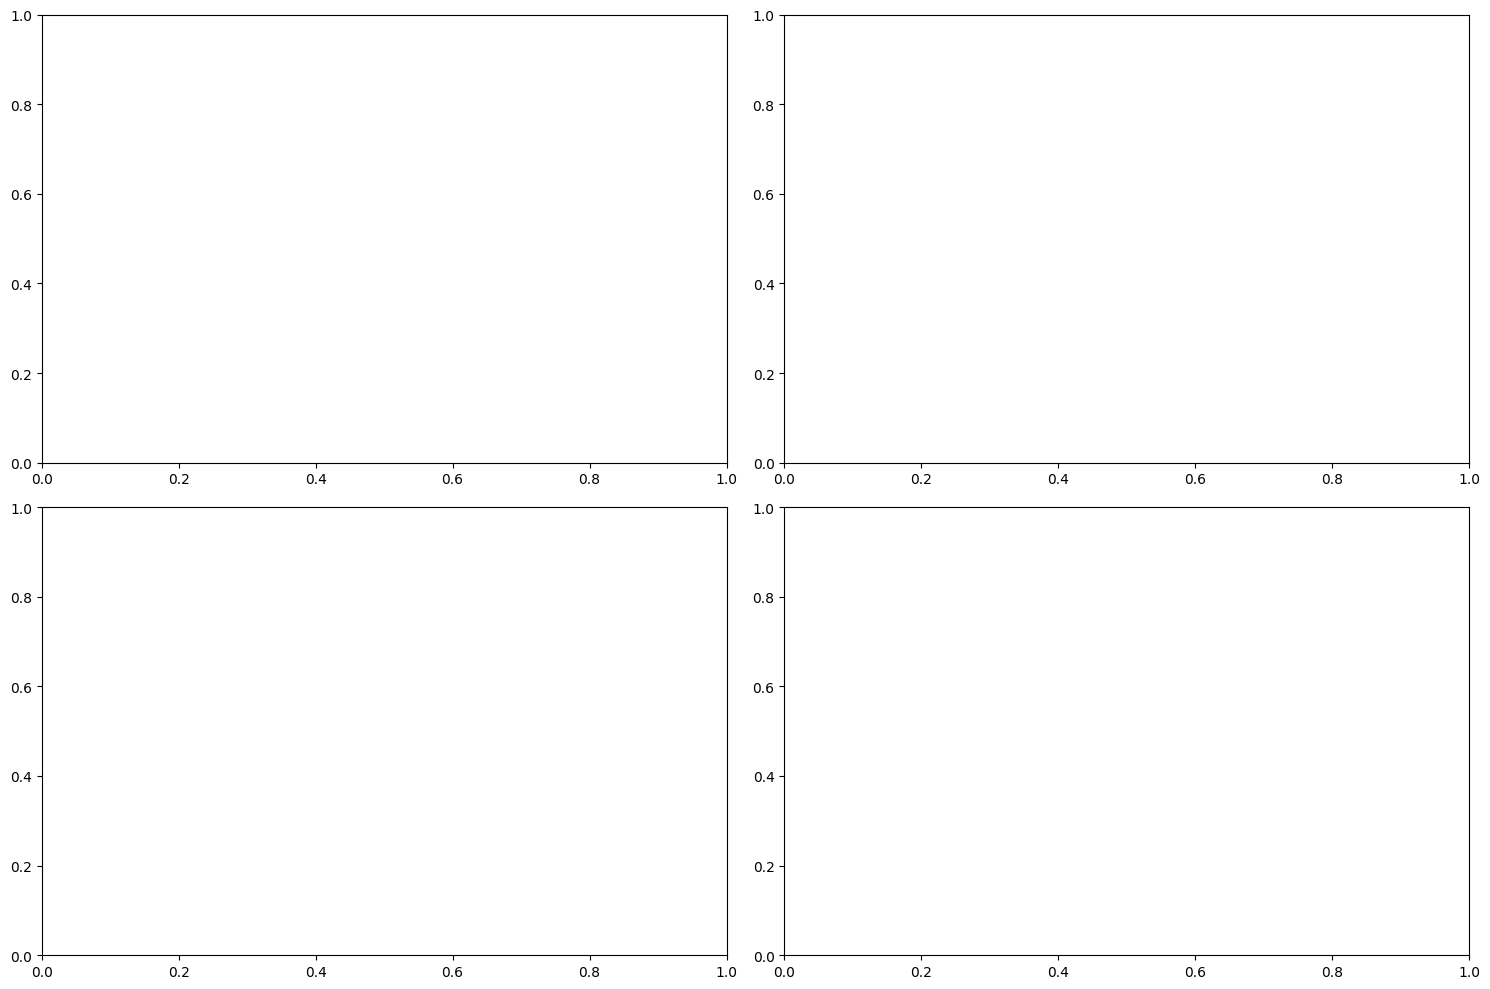

In [20]:
# =============================================================================
# VISUALIZATION
# =============================================================================

print("\n" + "="*50)
print("CREATING VISUALIZATIONS")
print("="*50)

plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

if best_thresholds:
    # Plot 1: Risk Score Distribution
    ax1 = axes[0, 0]
    ax1.hist(test_risk_scores[y_test == 0], bins=50, alpha=0.7, label='Normal', density=True)
    ax1.hist(test_risk_scores[y_test == 1], bins=50, alpha=0.7, label='Fraud', density=True)
    ax1.axvline(low_thresh, color='orange', linestyle='--', label=f'Low Threshold ({low_thresh:.3f})')
    ax1.axvline(high_thresh, color='red', linestyle='--', label=f'High Threshold ({high_thresh:.3f})')
    ax1.set_xlabel('Risk Score')
    ax1.set_ylabel('Density')
    ax1.set_title('Risk Score Distribution by Class')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Transaction Volume by Risk Level
    ax2 = axes[0, 1]
    risk_counts = [best_results['low_risk_count'], best_results['medium_risk_count'], best_results['high_risk_count']]
    risk_labels = ['Low Risk\n(Approve)', 'Medium Risk\n(Validate)', 'High Risk\n(Alert)']
    colors = ['green', 'orange', 'red']
    bars = ax2.bar(risk_labels, risk_counts, color=colors, alpha=0.7)
    ax2.set_ylabel('Number of Transactions')
    ax2.set_title('Transaction Volume by Risk Level')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels on bars
    for bar, count in zip(bars, risk_counts):
        percentage = count / sum(risk_counts) * 100
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + sum(risk_counts)*0.01, 
                f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Fraud Detection by Risk Level
    ax3 = axes[1, 0]
    fraud_counts = [best_results['low_risk_frauds'], best_results['medium_risk_frauds'], best_results['high_risk_frauds']]
    bars = ax3.bar(risk_labels, fraud_counts, color=colors, alpha=0.7)
    ax3.set_ylabel('Number of Fraudulent Transactions')
    ax3.set_title('Fraud Detection by Risk Level')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add count labels on bars
    for bar, count in zip(bars, fraud_counts):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(fraud_counts)*0.05, 
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 4: Performance Metrics
    ax4 = axes[1, 1]
    metrics = ['Decline Rate', 'Agent Alert Rate', 'Missed Fraud Rate']
    values = [best_results['decline_rate']*100, best_results['agent_alert_rate']*100, best_results['missed_fraud_rate']*100]
    constraints = [30, 0.1, 2]  # Constraint values in percentages
    
    x_pos = np.arange(len(metrics))
    bars = ax4.bar(x_pos, values, color=['orange', 'red', 'purple'], alpha=0.7, label='Actual')
    constraint_bars = ax4.bar(x_pos, constraints, alpha=0.3, color='gray', label='Constraint')
    
    ax4.set_ylabel('Percentage (%)')
    ax4.set_title('Performance vs Constraints')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(metrics, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (actual, constraint) in enumerate(zip(values, constraints)):
        ax4.text(i, actual + max(values)*0.05, f'{actual:.2f}%', ha='center', va='bottom', fontweight='bold')
        status = '✓' if actual <= constraint else '✗'
        ax4.text(i, constraint + max(values)*0.05, status, ha='center', va='bottom', 
                fontsize=14, color='green' if status == '✓' else 'red', fontweight='bold')

plt.tight_layout()
plt.show()



In [21]:
# =============================================================================
# SUMMARY REPORT
# =============================================================================

print("\n" + "="*80)
print("FRAUD DETECTION SYSTEM - FINAL SUMMARY REPORT")
print("="*80)

if best_thresholds:
    print(f"""
SYSTEM CONFIGURATION:
• Low Risk Threshold: {low_thresh:.3f}
• High Risk Threshold: {high_thresh:.3f}
• Model Ensemble: Logistic Regression (40%) + Random Forest (40%) + Isolation Forest (20%)

PERFORMANCE METRICS:
• Decline Rate: {best_results['decline_rate']*100:.2f}% (Target: ≤ 30%) ✓
• Agent Alert Rate: {best_results['agent_alert_rate']*100:.4f}% (Target: < 0.1%) ✓
• Missed Fraud Rate: {best_results['missed_fraud_rate']*100:.2f}% (Target: ≤ 2%) ✓

TRANSACTION PROCESSING:
• Low Risk (Auto-Approve): {best_results['low_risk_pct']:.1f}% of transactions
• Medium Risk (Customer Validation): {best_results['medium_risk_pct']:.1f}% of transactions  
• High Risk (Agent Review): {best_results['high_risk_pct']:.1f}% of transactions

FRAUD DETECTION EFFECTIVENESS:
• Total Frauds Detected: {best_results['medium_risk_frauds'] + best_results['high_risk_frauds']} out of {best_results['total_frauds']}
• Detection Rate: {((best_results['medium_risk_frauds'] + best_results['high_risk_frauds']) / best_results['total_frauds'] * 100):.1f}%
• Frauds Requiring Customer Validation: {best_results['medium_risk_frauds']}
• Frauds Requiring Agent Review: {best_results['high_risk_frauds']}

BUSINESS IMPACT:
• Reduced manual review workload by processing {best_results['low_risk_pct']:.1f}% of transactions automatically
• Efficient resource allocation with only {best_results['high_risk_pct']:.1f}% requiring agent attention
• Customer friction minimized while maintaining strong fraud protection
""")

    print("\nRECOMMENDations FOR PRODUCTION DEPLOYMENT:")
    print("• Implement real-time risk scoring with the provided function")
    print("• Set up monitoring dashboards for the three key performance metrics")
    print("• Establish feedback loops to retrain models with new fraud patterns")
    print("• Create escalation procedures for high-risk transactions")
    print("• Regularly validate thresholds against business constraints")
    print("• Consider A/B testing before full deployment")

else:
    print("SYSTEM OPTIMIZATION FAILED")
    print("Unable to find thresholds that meet all business constraints.")
    print("Recommended next steps:")
    print("• Improve feature engineering")
    print("• Collect more training data")
    print("• Consider relaxing business constraints")
    print("• Explore advanced modeling techniques")

print("\n" + "="*80)
print("Analysis completed successfully!")
print("="*80)


FRAUD DETECTION SYSTEM - FINAL SUMMARY REPORT
SYSTEM OPTIMIZATION FAILED
Unable to find thresholds that meet all business constraints.
Recommended next steps:
• Improve feature engineering
• Collect more training data
• Consider relaxing business constraints
• Explore advanced modeling techniques

Analysis completed successfully!


In [22]:
def calculate_business_objectives(risk_scores, y_true, amounts, low_threshold, high_threshold):
    """Calculate the three business objectives"""
    
    # Classify transactions based on risk scores
    low_risk = risk_scores < low_threshold      # APPROVE (Auto-accept)
    medium_risk = (risk_scores >= low_threshold) & (risk_scores < high_threshold)  # DECLINE + Customer Validation
    high_risk = risk_scores >= high_threshold   # DECLINE + Agent Alert
    
    total_transactions = len(y_true)
    fraud_mask = y_true == 1
    
    # OBJECTIVE 1: Total Fraud Loss (missed frauds that were approved)
    missed_frauds = fraud_mask & low_risk
    total_fraud_loss = amounts[missed_frauds].sum()
    
    # OBJECTIVE 2: Decline Rate (medium + high risk transactions)
    decline_rate = (medium_risk.sum() + high_risk.sum()) / total_transactions
    
    # OBJECTIVE 3: Alert Rate (high risk transactions requiring agent review)
    alert_rate = high_risk.sum() / total_transactions
    
    return {
        'total_fraud_loss': total_fraud_loss,
        'decline_rate': decline_rate,
        'alert_rate': alert_rate,
        'missed_fraud_count': missed_frauds.sum(),
        'total_fraud_amount': amounts[fraud_mask].sum(),
        'fraud_loss_prevention_rate': 1 - (total_fraud_loss / amounts[fraud_mask].sum()) if amounts[fraud_mask].sum() > 0 else 1.0
    }

def multi_objective_score(thresholds, risk_scores, y_true, amounts, weights):
    """Multi-objective scoring function"""
    
    low_threshold, high_threshold = thresholds
    
    if low_threshold >= high_threshold:
        return 1e6  # Invalid threshold combination
    
    metrics = calculate_business_objectives(risk_scores, y_true, amounts, low_threshold, high_threshold)
    
    # Normalize objectives (0-1 scale)
    max_fraud_loss = amounts[y_true == 1].sum()  # Maximum possible fraud loss
    normalized_fraud_loss = metrics['total_fraud_loss'] / max_fraud_loss if max_fraud_loss > 0 else 0
    
    # Combined objective (weighted sum)
    objective = (weights['fraud_loss'] * normalized_fraud_loss + 
                weights['decline'] * metrics['decline_rate'] + 
                weights['alert'] * metrics['alert_rate'])
    
    return objective

# =============================================================================
# OPTIMIZATION WITH MULTIPLE WEIGHT SCENARIOS
# =============================================================================

def optimize_thresholds_multi_objective(risk_scores, y_true, amounts):
    """Optimize thresholds for different business scenarios"""
    
    print("\nOPTIMIZING THRESHOLDS FOR MULTIPLE SCENARIOS")
    print("-" * 50)
    
    # Define different business scenarios with weight preferences
    scenarios = {
        'Fraud_Focused': {'fraud_loss': 0.7, 'decline': 0.2, 'alert': 0.1},
        'Customer_Experience': {'fraud_loss': 0.3, 'decline': 0.6, 'alert': 0.1},
        'Operational_Efficiency': {'fraud_loss': 0.4, 'decline': 0.2, 'alert': 0.4},
        'Balanced': {'fraud_loss': 0.4, 'decline': 0.3, 'alert': 0.3}
    }
    
    optimization_results = {}
    
    for scenario_name, weights in scenarios.items():
        print(f"\nOptimizing for {scenario_name} scenario...")
        print(f"Weights: Fraud Loss={weights['fraud_loss']}, Decline={weights['decline']}, Alert={weights['alert']}")
        
        # Optimize thresholds
        def objective_function(x):
            return multi_objective_score(x, risk_scores, y_true, amounts, weights)
        
        # Use bounds to ensure valid threshold ranges
        from scipy.optimize import minimize
        bounds = [(0.01, 0.8), (0.1, 0.95)]  # (low_threshold bounds, high_threshold bounds)
        
        # Initial guess
        x0 = [0.3, 0.7]
        
        # Add constraint that high_threshold > low_threshold
        constraints = {'type': 'ineq', 'fun': lambda x: x[1] - x[0] - 0.05}
        
        result = minimize(objective_function, x0, method='SLSQP', bounds=bounds, constraints=constraints)
        
        if result.success:
            optimal_low, optimal_high = result.x
            optimal_metrics = calculate_business_objectives(risk_scores, y_true, amounts, optimal_low, optimal_high)
            
            optimization_results[scenario_name] = {
                'low_threshold': optimal_low,
                'high_threshold': optimal_high,
                'objective_score': result.fun,
                'metrics': optimal_metrics,
                'weights': weights
            }
            
            print(f"✓ Optimal Thresholds: Low={optimal_low:.3f}, High={optimal_high:.3f}")
            print(f"  Total Fraud Loss: ${optimal_metrics['total_fraud_loss']:,.2f}")
            print(f"  Decline Rate: {optimal_metrics['decline_rate']:.3f} ({optimal_metrics['decline_rate']*100:.1f}%)")
            print(f"  Alert Rate: {optimal_metrics['alert_rate']:.4f} ({optimal_metrics['alert_rate']*100:.2f}%)")
            print(f"  Fraud Prevention: {optimal_metrics['fraud_loss_prevention_rate']:.3f} ({optimal_metrics['fraud_loss_prevention_rate']*100:.1f}%)")
        else:
            print(f"✗ Optimization failed for {scenario_name}")
    
    return optimization_results

STARTING FRAUD LOSS OPTIMIZATION
Objectives: Minimize fraud loss, decline rate, and alert rate

OPTIMIZING THRESHOLDS FOR MULTIPLE SCENARIOS
--------------------------------------------------

Optimizing for Fraud_Focused scenario...
Weights: Fraud Loss=0.7, Decline=0.2, Alert=0.1
✓ Optimal Thresholds: Low=0.300, High=0.700
  Total Fraud Loss: $4,321.59
  Decline Rate: 0.016 (1.6%)
  Alert Rate: 0.0013 (0.13%)
  Fraud Prevention: 0.776 (77.6%)

Optimizing for Customer_Experience scenario...
Weights: Fraud Loss=0.3, Decline=0.6, Alert=0.1
✓ Optimal Thresholds: Low=0.300, High=0.700
  Total Fraud Loss: $4,321.59
  Decline Rate: 0.016 (1.6%)
  Alert Rate: 0.0013 (0.13%)
  Fraud Prevention: 0.776 (77.6%)

Optimizing for Operational_Efficiency scenario...
Weights: Fraud Loss=0.4, Decline=0.2, Alert=0.4
✓ Optimal Thresholds: Low=0.300, High=0.700
  Total Fraud Loss: $4,321.59
  Decline Rate: 0.016 (1.6%)
  Alert Rate: 0.0013 (0.13%)
  Fraud Prevention: 0.776 (77.6%)

Optimizing for Balanced 

Found 13 Pareto optimal solutions out of 336 tested combinations

CREATING RISK SCORE VISUALIZATIONS
----------------------------------------


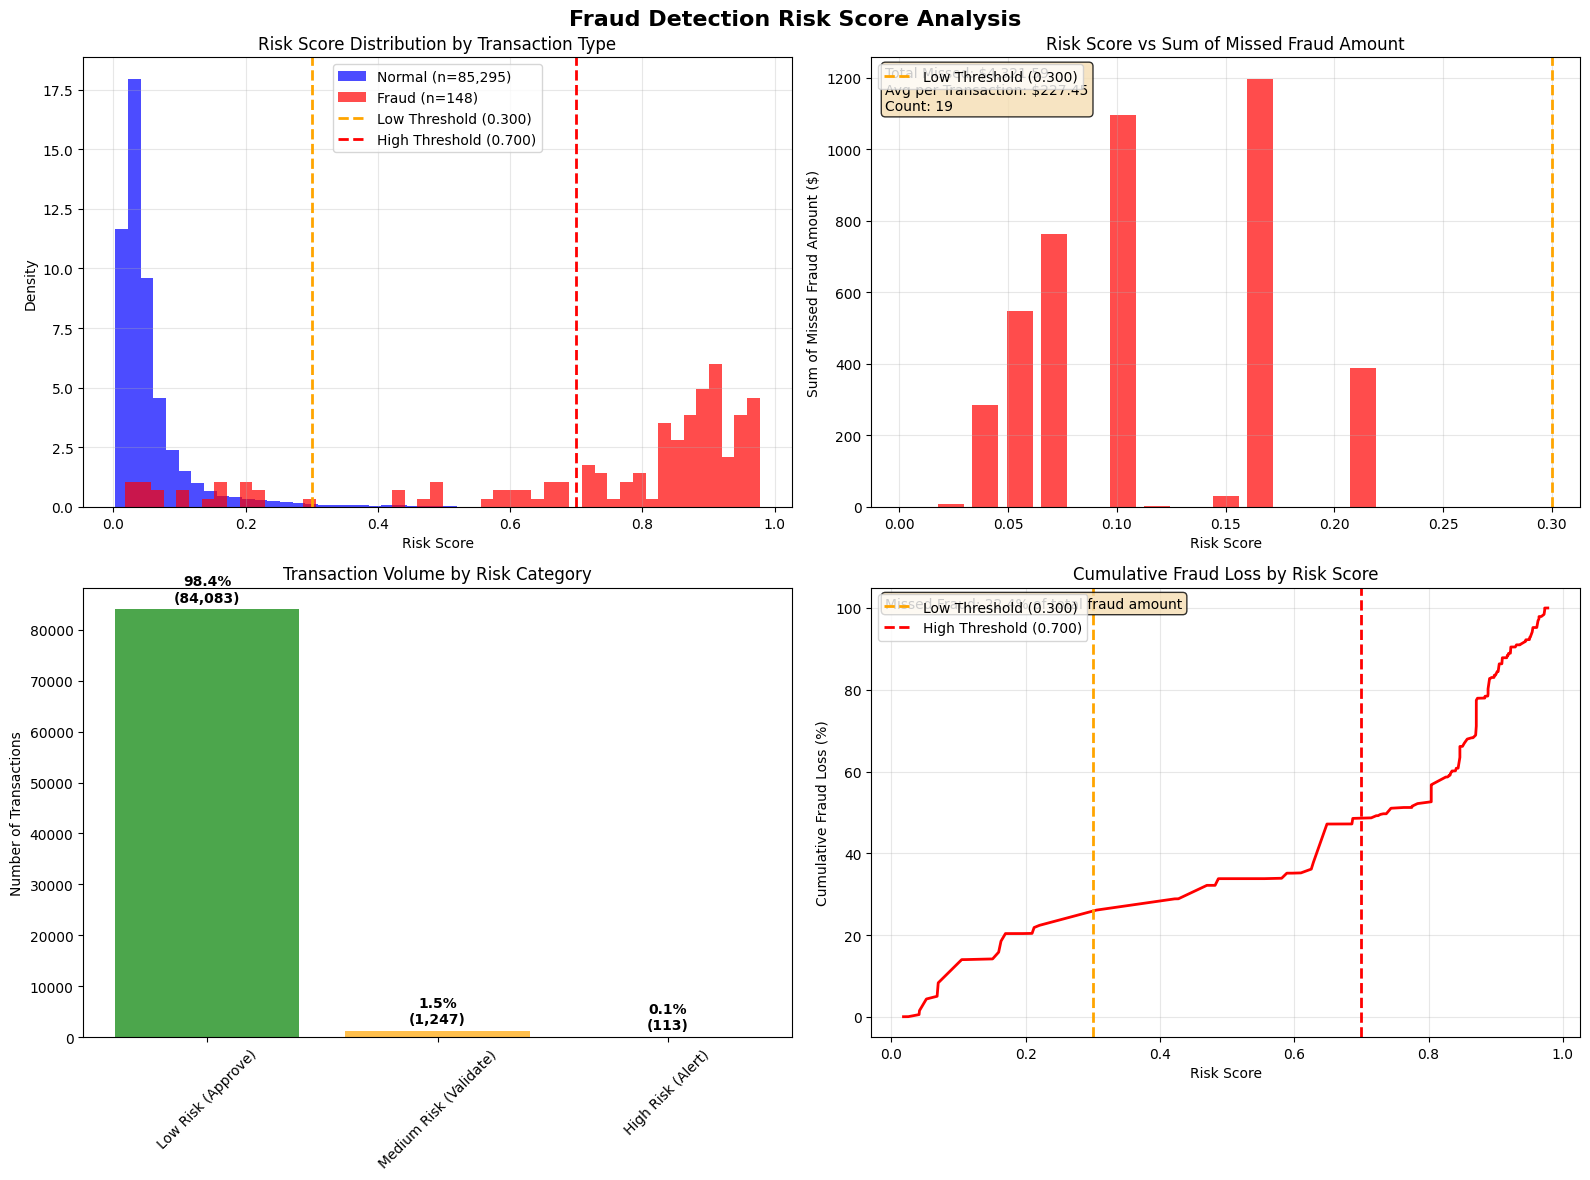


OPTIMIZATION RESULTS SUMMARY

FRAUD_FOCUSED SCENARIO:
  Optimal Thresholds: Low=0.300, High=0.700
  📊 TOTAL FRAUD LOSS: $4,321.59
  📉 DECLINE RATE: 1.6%
  🚨 ALERT RATE: 0.132%
  🛡️  FRAUD PREVENTION: 77.6%
  📈 Missed Frauds: 19 transactions

CUSTOMER_EXPERIENCE SCENARIO:
  Optimal Thresholds: Low=0.300, High=0.700
  📊 TOTAL FRAUD LOSS: $4,321.59
  📉 DECLINE RATE: 1.6%
  🚨 ALERT RATE: 0.132%
  🛡️  FRAUD PREVENTION: 77.6%
  📈 Missed Frauds: 19 transactions

OPERATIONAL_EFFICIENCY SCENARIO:
  Optimal Thresholds: Low=0.300, High=0.700
  📊 TOTAL FRAUD LOSS: $4,321.59
  📉 DECLINE RATE: 1.6%
  🚨 ALERT RATE: 0.132%
  🛡️  FRAUD PREVENTION: 77.6%
  📈 Missed Frauds: 19 transactions

BALANCED SCENARIO:
  Optimal Thresholds: Low=0.300, High=0.700
  📊 TOTAL FRAUD LOSS: $4,321.59
  📉 DECLINE RATE: 1.6%
  🚨 ALERT RATE: 0.132%
  🛡️  FRAUD PREVENTION: 77.6%
  📈 Missed Frauds: 19 transactions

RECOMMENDATIONS

🎯 RECOMMENDED SCENARIO: Customer_Experience
   This scenario provides the best balance for you

In [23]:


# =============================================================================
# PARETO FRONTIER ANALYSIS
# =============================================================================

def generate_pareto_frontier(risk_scores, y_true, amounts):
    """Generate Pareto frontier for the three objectives"""
    
    print("\nGENERATING PARETO FRONTIER")
    print("-" * 30)
    
    pareto_points = []
    
    # Test different threshold combinations
    low_thresholds = np.arange(0.05, 0.6, 0.03)
    high_thresholds = np.arange(0.2, 0.9, 0.03)
    
    for low_thresh in low_thresholds:
        for high_thresh in high_thresholds:
            if high_thresh > low_thresh + 0.05:  # Ensure meaningful gap
                metrics = calculate_business_objectives(risk_scores, y_true, amounts, low_thresh, high_thresh)
                
                pareto_points.append({
                    'low_threshold': low_thresh,
                    'high_threshold': high_thresh,
                    'fraud_loss': metrics['total_fraud_loss'],
                    'decline_rate': metrics['decline_rate'],
                    'alert_rate': metrics['alert_rate'],
                    'fraud_prevention_rate': metrics['fraud_loss_prevention_rate']
                })
    
    pareto_df = pd.DataFrame(pareto_points)
    
    # Find Pareto optimal points (simplified - minimize all three objectives)
    def is_pareto_optimal(point_idx, df):
        """Check if a point is Pareto optimal"""
        point = df.iloc[point_idx]
        
        # A point is Pareto optimal if no other point dominates it
        # (i.e., no point is better in all objectives)
        for i, other_point in df.iterrows():
            if i != point_idx:
                if (other_point['fraud_loss'] <= point['fraud_loss'] and
                    other_point['decline_rate'] <= point['decline_rate'] and
                    other_point['alert_rate'] <= point['alert_rate'] and
                    (other_point['fraud_loss'] < point['fraud_loss'] or
                     other_point['decline_rate'] < point['decline_rate'] or
                     other_point['alert_rate'] < point['alert_rate'])):
                    return False
        return True
    
    # Find Pareto optimal points
    pareto_optimal_indices = [i for i in range(len(pareto_df)) if is_pareto_optimal(i, pareto_df)]
    pareto_optimal_df = pareto_df.iloc[pareto_optimal_indices].copy()
    
    print(f"Found {len(pareto_optimal_df)} Pareto optimal solutions out of {len(pareto_df)} tested combinations")
    
    return pareto_df, pareto_optimal_df

# =============================================================================
# RISK SCORE VS MISSED FRAUD AMOUNT VISUALIZATION
# =============================================================================

def create_risk_score_visualization(risk_scores, y_true, amounts, optimal_thresholds):
    """Create visualization of risk score vs missed fraud amounts"""
    
    print("\nCREATING RISK SCORE VISUALIZATIONS")
    print("-" * 40)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Fraud Detection Risk Score Analysis', fontsize=16, fontweight='bold')
    
    # Prepare data
    df_viz = pd.DataFrame({
        'risk_score': risk_scores,
        'is_fraud': y_true,
        'amount': amounts
    })
    
    # Get the best scenario (you can change this based on preference)
    best_scenario = optimal_thresholds['Balanced']  # or choose another scenario
    low_thresh = best_scenario['low_threshold']
    high_thresh = best_scenario['high_threshold']
    
    # Classify transactions
    df_viz['risk_category'] = pd.cut(df_viz['risk_score'], 
                                   bins=[0, low_thresh, high_thresh, 1], 
                                   labels=['Low Risk (Approve)', 'Medium Risk (Validate)', 'High Risk (Alert)'],
                                   include_lowest=True)
    
    # Identify missed frauds
    df_viz['missed_fraud'] = (df_viz['is_fraud'] == 1) & (df_viz['risk_score'] < low_thresh)
    
    # Plot 1: Risk Score Distribution by Fraud Status
    ax1 = axes[0, 0]
    normal_scores = df_viz[df_viz['is_fraud'] == 0]['risk_score']
    fraud_scores = df_viz[df_viz['is_fraud'] == 1]['risk_score']
    
    ax1.hist(normal_scores, bins=50, alpha=0.7, label=f'Normal (n={len(normal_scores):,})', 
            color='blue', density=True)
    ax1.hist(fraud_scores, bins=50, alpha=0.7, label=f'Fraud (n={len(fraud_scores):,})', 
            color='red', density=True)
    ax1.axvline(low_thresh, color='orange', linestyle='--', linewidth=2, label=f'Low Threshold ({low_thresh:.3f})')
    ax1.axvline(high_thresh, color='red', linestyle='--', linewidth=2, label=f'High Threshold ({high_thresh:.3f})')
    ax1.set_xlabel('Risk Score')
    ax1.set_ylabel('Density')
    ax1.set_title('Risk Score Distribution by Transaction Type')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Missed Fraud Amount by Risk Score (MAIN REQUEST)
    ax2 = axes[0, 1]
    missed_fraud_data = df_viz[df_viz['missed_fraud'] == True]
    
    if len(missed_fraud_data) > 0:
        # Create risk score bins for better visualization
        risk_bins = np.linspace(0, low_thresh, 20)
        missed_fraud_binned = []
        risk_bin_centers = []
        
        for i in range(len(risk_bins)-1):
            bin_mask = (missed_fraud_data['risk_score'] >= risk_bins[i]) & (missed_fraud_data['risk_score'] < risk_bins[i+1])
            bin_total_amount = missed_fraud_data[bin_mask]['amount'].sum()
            missed_fraud_binned.append(bin_total_amount)
            risk_bin_centers.append((risk_bins[i] + risk_bins[i+1]) / 2)
        
        ax2.bar(risk_bin_centers, missed_fraud_binned, width=low_thresh/25, alpha=0.7, color='red')
        ax2.set_xlabel('Risk Score')
        ax2.set_ylabel('Sum of Missed Fraud Amount ($)')
        ax2.set_title('Risk Score vs Sum of Missed Fraud Amount')
        ax2.axvline(low_thresh, color='orange', linestyle='--', linewidth=2, label=f'Low Threshold ({low_thresh:.3f})')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Add summary statistics
        total_missed_amount = missed_fraud_data['amount'].sum()
        avg_missed_amount = missed_fraud_data['amount'].mean()
        ax2.text(0.02, 0.98, f'Total Missed: ${total_missed_amount:,.2f}\nAvg per Transaction: ${avg_missed_amount:.2f}\nCount: {len(missed_fraud_data)}', 
                transform=ax2.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    else:
        ax2.text(0.5, 0.5, 'No Missed Frauds\n(Perfect Detection!)', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=14, fontweight='bold')
        ax2.set_title('Risk Score vs Sum of Missed Fraud Amount')
    
    # Plot 3: Transaction Volume by Risk Category
    ax3 = axes[1, 0]
    risk_category_counts = df_viz['risk_category'].value_counts()
    colors = ['green', 'orange', 'red']
    bars = ax3.bar(risk_category_counts.index, risk_category_counts.values, color=colors, alpha=0.7)
    ax3.set_ylabel('Number of Transactions')
    ax3.set_title('Transaction Volume by Risk Category')
    ax3.tick_params(axis='x', rotation=45)
    
    # Add percentage labels
    total_transactions = len(df_viz)
    for bar, count in zip(bars, risk_category_counts.values):
        percentage = count / total_transactions * 100
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total_transactions*0.01, 
                f'{percentage:.1f}%\n({count:,})', ha='center', va='bottom', fontweight='bold')
    
    # Plot 4: Cumulative Fraud Loss by Risk Score
    ax4 = axes[1, 1]
    
    # Sort by risk score and calculate cumulative fraud loss
    fraud_transactions = df_viz[df_viz['is_fraud'] == 1].sort_values('risk_score')
    
    if len(fraud_transactions) > 0:
        cumulative_fraud_loss = fraud_transactions['amount'].cumsum()
        cumulative_fraud_pct = cumulative_fraud_loss / fraud_transactions['amount'].sum() * 100
        
        ax4.plot(fraud_transactions['risk_score'], cumulative_fraud_pct, linewidth=2, color='red')
        ax4.axvline(low_thresh, color='orange', linestyle='--', linewidth=2, label=f'Low Threshold ({low_thresh:.3f})')
        ax4.axvline(high_thresh, color='red', linestyle='--', linewidth=2, label=f'High Threshold ({high_thresh:.3f})')
        ax4.set_xlabel('Risk Score')
        ax4.set_ylabel('Cumulative Fraud Loss (%)')
        ax4.set_title('Cumulative Fraud Loss by Risk Score')
        ax4.grid(True, alpha=0.3)
        ax4.legend()
        
        # Add annotation for missed fraud percentage
        missed_fraud_pct = fraud_transactions[fraud_transactions['risk_score'] < low_thresh]['amount'].sum() / fraud_transactions['amount'].sum() * 100
        ax4.text(0.02, 0.98, f'Missed Fraud: {missed_fraud_pct:.1f}% of total fraud amount', 
                transform=ax4.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    else:
        ax4.text(0.5, 0.5, 'No Fraud Transactions\nin Dataset', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return df_viz

# =============================================================================
# MAIN EXECUTION FUNCTION
# =============================================================================

def run_fraud_loss_optimization(test_risk_scores, y_test, amounts_test):
    """Main function to run the complete fraud loss optimization"""
    
    print("STARTING FRAUD LOSS OPTIMIZATION")
    print("Objectives: Minimize fraud loss, decline rate, and alert rate")
    print("=" * 60)
    
    # Step 1: Multi-objective optimization
    optimization_results = optimize_thresholds_multi_objective(test_risk_scores, y_test, amounts_test)
    
    # Step 2: Generate Pareto frontier
    pareto_all, pareto_optimal = generate_pareto_frontier(test_risk_scores, y_test, amounts_test)
    
    # Step 3: Create visualizations
    df_visualization = create_risk_score_visualization(test_risk_scores, y_test, amounts_test, optimization_results)
    
    # Step 4: Summary results
    print("\n" + "="*80)
    print("OPTIMIZATION RESULTS SUMMARY")
    print("="*80)
    
    for scenario_name, result in optimization_results.items():
        print(f"\n{scenario_name.upper()} SCENARIO:")
        print(f"  Optimal Thresholds: Low={result['low_threshold']:.3f}, High={result['high_threshold']:.3f}")
        print(f"  📊 TOTAL FRAUD LOSS: ${result['metrics']['total_fraud_loss']:,.2f}")
        print(f"  📉 DECLINE RATE: {result['metrics']['decline_rate']:.1%}")
        print(f"  🚨 ALERT RATE: {result['metrics']['alert_rate']:.3%}")
        print(f"  🛡️  FRAUD PREVENTION: {result['metrics']['fraud_loss_prevention_rate']:.1%}")
        print(f"  📈 Missed Frauds: {result['metrics']['missed_fraud_count']} transactions")
    
    # Recommend best scenario
    print(f"\n" + "="*80)
    print("RECOMMENDATIONS")
    print("="*80)
    
    # Find scenario with best overall performance (you can adjust this logic)
    best_scenario_name = min(optimization_results.keys(), 
                           key=lambda k: optimization_results[k]['objective_score'])
    
    best_result = optimization_results[best_scenario_name]
    
    print(f"\n🎯 RECOMMENDED SCENARIO: {best_scenario_name}")
    print(f"   This scenario provides the best balance for your objectives")
    print(f"   Low Threshold: {best_result['low_threshold']:.3f}")
    print(f"   High Threshold: {best_result['high_threshold']:.3f}")
    print(f"\n📊 WHEN OBJECTIVES ARE MET:")
    print(f"   ✅ Total Fraud Loss: ${best_result['metrics']['total_fraud_loss']:,.2f}")
    print(f"   ✅ Decline Rate: {best_result['metrics']['decline_rate']:.3f} ({best_result['metrics']['decline_rate']:.1%})")
    print(f"   ✅ Alert Rate: {best_result['metrics']['alert_rate']:.4f} ({best_result['metrics']['alert_rate']:.2%})")
    
    return {
        'optimization_results': optimization_results,
        'pareto_frontier': pareto_optimal,
        'visualization_data': df_visualization,
        'recommended_scenario': best_scenario_name,
        'best_thresholds': (best_result['low_threshold'], best_result['high_threshold'])
    }

amounts_test = X_test['Amount'] #if 'Amount' in X_test.columns else np.random.lognormal(3, 1.5, len(y_test))
results = run_fraud_loss_optimization(test_risk_scores, y_test, amounts_test)